# Explainer Notebook

This notebook is structured into 4 sections:
* Motivation
* Basic Stats
* Tools, theory and analysis
* Discussion

The starting point will be numerous imports relevant for the entire notebook!

In [17]:
# imports
import os
import pickle
import random
import re
import warnings
from collections import Counter, defaultdict

import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import netwulf as nw
import nltk
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency, ttest_1samp
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.auto import tqdm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

warnings.filterwarnings("ignore")
random.seed(42)
np.random.seed(42)

## Motivation

This brief section will cover the motivation behind this project.

- What is your dataset?

The dataset behind this project is the Pokémon world, i.e. all the Pokémon found in the Pokédex using PokeAPI, and all the episodes from the Pokémon TV-show collected from Bulbapedia. Using the Pokédex, it was possible to extract all the names of each Pokémon as well as some attributes such as their type, abilities, and egg groups which are important in the games. From Bulbapedia, it was possible to scrape the plots of each episode from each season as well as lists of which Pokémon appeared in which episodes. This is relevant for graph purposes. 

- Why did you choose this/these particular dataset(s)?

We initially thought it would be interesting to go in a different direction than taking a "real-world" dataset, and see if it was still possible to apply methods from this course, and perform a relevant analysis. As such, we needed as much data from the Pokémon world as possible such that it was both possible to construct a graph with a number of attributes, and also have some text to analyse. 

- What was your goal for the end user’s experience?

The goal for the end user is to gain insight into the Pokémon world, and get a brief grasp of the different seasons, what separates them, and what makes them unique. This is the hope for someone who would come across this project. Essentially, this project can be boiled down to the following research questions:

1. What characterizes the network for each season of the Pokémon Anime.

2. Are there any similarities or differences between the various seasons and if so, what are these?

3. How do the seasons themselves separate each other w.r.t. their plots, and are there any similarities or differences between seasons?

These will lead the analysis done below.

## Basic Stats

Now, the focus will be shifted onto data collection and preprocessing. For this, numerous functions will be used, and these will be defined below.

- `data_scrape(pokemon_names)`: Scrapes data from PokéAPI given a list of Pokémon names, and returns this data in a dict format.
- `find_unique(df, col)`: Find the unique vales given a Pandas dataframe, and a column name.

In [3]:
def data_scrape(pokemon_names):
    # scrape the data from PokéAPI
    temp_dict = {
        "pokemon": [],
        "abilities": [],
        "types": [],
        "egg_groups": [],
        "moves": [],
        "pokedex_entry": [],
    }

    for i, name in tqdm(enumerate(pokemon_names)):
        r = requests.get("https://pokeapi.co/api/v2/pokemon/" + str(i + 1)).json()
        # append the name of the pokemon
        temp_dict["pokemon"].append(name)

        # append the abilities of the pokemon
        abilities = [
            r["abilities"][j]["ability"]["name"] for j in range(len(r["abilities"]))
        ]
        temp_dict["abilities"].append(abilities)

        # append the types of the pokemon
        types = [r["types"][i]["type"]["name"] for i in range(len(r["types"]))]
        temp_dict["types"].append(types)

        # append the moves of the pokemon
        moves = [r["moves"][j]["move"]["name"] for j in range(len(r["moves"]))]
        temp_dict["moves"].append(moves)

        # make new request to get the egg groups and pokedex entry
        r = requests.get(
            "https://pokeapi.co/api/v2/pokemon-species/" + str(i + 1)
        ).json()

        # append the egg groups of the pokemon
        egg_groups = [r["egg_groups"][j]["name"] for j in range(len(r["egg_groups"]))]
        temp_dict["egg_groups"].append(egg_groups)

        # append the pokedex entry of the pokemon
        entry = (
            r["flavor_text_entries"][0]["flavor_text"]
            .replace("\n", " ")
            .replace("\f", " ")
            if len(r["flavor_text_entries"]) > 0
            else None
        )
        temp_dict["pokedex_entry"].append(entry)

    print("Done!")

    return temp_dict


def find_unique(df, col):
    vals = df[col].values
    all_vals = [item for sublist in vals for item in sublist]
    unique_vals = list(set(all_vals))
    return unique_vals

With the functions defined, we start the proces of collection our list of Pokémon names.

In [4]:
# make the initial request to get the pokemon names
data = requests.get("https://pokeapi.co/api/v2/pokemon?limit=1000").json()["results"]

# get the names of the pokemons
pokemons = []
# get the name of the pokemon
for i in range(len(data)):
    pokemons.append(data[i]["name"])

print("Check the first 5 pokemons: ", pokemons[:5])
print("The total number of pokemons: ", len(pokemons))

Check the first 5 pokemons:  ['bulbasaur', 'ivysaur', 'venusaur', 'charmander', 'charmeleon']
The total number of pokemons:  1000


We see that the code works as intended!

This list of Pokémon names is now ready to be used in the `data_scrape()` function to gather the data.

In [4]:
# next, use the function to create the dataset (only if the file does not exist)
if not os.path.exists("pokemon.pickle"):
    print("Scraping data...")
    poke_dict = data_scrape(pokemon_names=pokemons)
    poke_df = pd.DataFrame(poke_dict)
    poke_df.to_pickle("pokemon.pickle")
else:
    poke_df = pd.read_pickle("pokemon.pickle")
    print("Data loaded!")

Data loaded!


In [5]:
# check the info of the dataframe to get a quick overview
poke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   pokemon        1000 non-null   object
 1   abilities      1000 non-null   object
 2   types          1000 non-null   object
 3   egg_groups     1000 non-null   object
 4   moves          1000 non-null   object
 5   pokedex_entry  905 non-null    object
dtypes: object(6)
memory usage: 47.0+ KB


Now that the initial dataframe has been gathered there is a need for some cleaning. This is done in 2 simple steps:
1. Remove all NaN values. These are the entries that does not have a pokedex entry.
2. Capitalize the names of each Pokémon.

In [6]:
# first, remove NaN values
poke_df_clean = poke_df.dropna()

# second, capitalize the pokemon names
poke_df_clean["pokemon"] = poke_df_clean["pokemon"].str.capitalize()

In [7]:
# finally, we save the cleaned dataframe to a pickle file (only if the file does not exist)
poke_df_clean.to_pickle("pokemon_clean.pickle") if not os.path.exists(
    "pokemon_clean.pickle"
) else print("File already exists")

File already exists


The next step is to check the unique values in each of the columns of the dataframe. This is simply to gain a quick overview of how many there are of each.

In [8]:
unique_abilities = find_unique(poke_df_clean, "abilities")
unique_types = find_unique(poke_df_clean, "types")
unique_egg_groups = find_unique(poke_df_clean, "egg_groups")
unique_moves = find_unique(poke_df_clean, "moves")
print("Number of pokemon: ", len(poke_df_clean))
print("Number of unique abilities: ", len(unique_abilities))
print("Number of unique types: ", len(unique_types))
print("Number of unique egg groups: ", len(unique_egg_groups))
print("Number of unique moves: ", len(unique_moves))

Number of pokemon:  905
Number of unique abilities:  249
Number of unique types:  18
Number of unique egg groups:  15
Number of unique moves:  747


This sums up the initial dataset preprocessing. This means that going forward, this project will only consider the 905 Pokémon found above. It is important to note that there are 249 unique abilities, 18 unique types and 15 unique egg groups, and this will become important during the graph analysis. Do however also note, there are many more combinations of these.

The next step is to collect data from all the Pokémon seasons. This process is a little more complicated, and as before it starts with defining a couple of functions.

- `make_number()`: Given a number, returns it on correct format for calling the Bulbapedia website.
- `get_pokemon_data()`: Given an episode (number), a list of Pokémon names, and a season ID, returns the unique Pokémon found in this episode.
- `get_episode_plot()`: Given an episode (number) and a season ID, returns the plot for this episode.
- `gather_pokemon_data()`: Given a list of episode numbers, a list of Pokémon names, and a season ID, returns the data for the full season in a dict format.

In [9]:
def make_number(num):
    if num < 10:
        return "00" + str(num)
    elif num < 100:
        return "0" + str(num)
    else:
        return str(num)


def get_pokemon_data(episode, names, season):
    lookup = season_dict[season]
    r = requests.get(
        os.path.join("https://bulbapedia.bulbagarden.net/wiki", lookup + episode)
    ).text
    soup = BeautifulSoup(r, "html.parser")
    elems = soup.find_all("a", href=True)
    episode_pokemon = []

    for name in names:
        for elem in elems:
            if name in elem.text:
                text = elem.text
                episode_pokemon.append(text)

    unique_pokemon = list(set(episode_pokemon))

    # remove elements that are not single words
    unique_pokemon = [p for p in unique_pokemon if len(p.split()) == 1]

    # remove nature names
    if "Nature" in unique_pokemon:
        unique_pokemon.remove("Nature")
    return unique_pokemon


# get episode plots
def get_episode_plot(episode, season):
    lookup = season_dict[season]
    r = requests.get(
        os.path.join("https://bulbapedia.bulbagarden.net/wiki", lookup + episode)
    ).text
    soup = BeautifulSoup(r, "html.parser")
    elems = soup.find_all("p")
    plot = ""
    for i in range(1, len(elems)):
        if "Who's That Pokémon?" in elems[i].text:
            break
        plot += elems[i].text

    # plot = plot.replace('\n ', ' ')
    plot = plot.replace("\n", " ")

    # remove trailing whitespace
    plot = plot.strip()

    return plot


def gather_pokemon_data(episode_numbers, names, season):
    episode_dict = {}
    for episode in tqdm(episode_numbers):
        episode_pokemon = get_pokemon_data(episode, names, season)
        plot = get_episode_plot(episode, season)
        episode_dict[episode] = []
        episode_dict[episode].append(episode_pokemon)
        episode_dict[episode].append(plot)
    return episode_dict

In [10]:
# now, we can get the pokemon data for each episode
# first, we get the names of all pokemon from the initial dataframe
names = poke_df_clean["pokemon"].values.tolist()

In [11]:
# then, we start collecting data for each season
# this requires a bit of manual work, since the episodes are not numbered in a consistent way
# also, we need a season dict
season_dict = {
    "Indigo League": "EP",
    "Adventures on the Orange Islands": "EP",
    "The Johto Journeys": "EP",
    "Hoenn": "AG",
    "Battle Frontier": "AG",
    "Diamond and Pearl": "DP",
    "Black and White": "BW",
    "XY": "XY",
    "Sun and Moon": "SM",
    "Pocket Monsters": "JN",
}

In [12]:
if not os.path.exists("indigo_df.pkl"):
    print("Scraping data...")
    episode_numbers_indigo_league = [make_number(i) for i in range(1, 81)]
    indigo_dict = gather_pokemon_data(
        episode_numbers_indigo_league, names, "Indigo League"
    )
    indigo_df = pd.DataFrame.from_dict(
        indigo_dict, orient="index", columns=["pokemon", "plot"]
    )
    indigo_df.to_pickle("indigo_df.pkl")
else:
    indigo_df = pd.read_pickle("indigo_df.pkl")
    print("Data loaded!")

Data loaded!


In [13]:
if not os.path.exists("orange_df.pkl"):
    print("Scraping data...")
    episode_numbers_orange_islands = [make_number(i) for i in range(81, 117)]
    orange_dict = gather_pokemon_data(
        episode_numbers_orange_islands, names, "Adventures on the Orange Islands"
    )
    orange_df = pd.DataFrame.from_dict(
        orange_dict, orient="index", columns=["pokemon", "plot"]
    )
    orange_df.to_pickle("orange_df.pkl")
else:
    orange_df = pd.read_pickle("orange_df.pkl")
    print("Data loaded!")

Data loaded!


In [14]:
if not os.path.exists("johto_df.pkl"):
    print("Scraping data...")
    episode_numbers_johto_journeys = [make_number(i) for i in range(117, 275)]
    johto_dict = gather_pokemon_data(
        episode_numbers_johto_journeys, names, "The Johto Journeys"
    )
    johto_df = pd.DataFrame.from_dict(
        johto_dict, orient="index", columns=["pokemon", "plot"]
    )
    johto_df.to_pickle("johto_df.pkl")
else:
    johto_df = pd.read_pickle("johto_df.pkl")
    print("Data loaded!")

Data loaded!


In [15]:
if not os.path.exists("hoenn_df.pkl"):
    print("Scraping data...")
    episode_numbers_hoenn_league = [make_number(i) for i in range(1, 135)]
    hoenn_dict = gather_pokemon_data(episode_numbers_hoenn_league, names, "Hoenn")
    hoenn_df = pd.DataFrame.from_dict(
        hoenn_dict, orient="index", columns=["pokemon", "plot"]
    )
    hoenn_df.to_pickle("hoenn_df.pkl")
else:
    hoenn_df = pd.read_pickle("hoenn_df.pkl")
    print("Data loaded!")

Data loaded!


In [16]:
if not os.path.exists("battle_df.pkl"):
    print("Scraping data...")
    episode_numbers_battle_frontier = [make_number(i) for i in range(135, 193)]
    battle_dict = gather_pokemon_data(
        episode_numbers_battle_frontier, names, "Battle Frontier"
    )
    battle_df = pd.DataFrame.from_dict(
        battle_dict, orient="index", columns=["pokemon", "plot"]
    )
    battle_df.to_pickle("battle_df.pkl")
else:
    battle_df = pd.read_pickle("battle_df.pkl")
    print("Data loaded!")

Data loaded!


In [17]:
if not os.path.exists("diamond_df.pkl"):
    print("Scraping data...")
    episode_numbers_diamond_pearl = [make_number(i) for i in range(1, 192)]
    diamond_dict = gather_pokemon_data(
        episode_numbers_diamond_pearl, names, "Diamond and Pearl"
    )
    diamond_df = pd.DataFrame.from_dict(
        diamond_dict, orient="index", columns=["pokemon", "plot"]
    )
    diamond_df.to_pickle("diamond_df.pkl")
else:
    diamond_df = pd.read_pickle("diamond_df.pkl")
    print("Data loaded!")

Data loaded!


In [18]:
if not os.path.exists("black_df.pkl"):
    print("Scraping data...")
    episode_numbers_black_white = [make_number(i) for i in range(1, 143)]
    black_dict = gather_pokemon_data(
        episode_numbers_black_white, names, "Black and White"
    )
    black_df = pd.DataFrame.from_dict(
        black_dict, orient="index", columns=["pokemon", "plot"]
    )
    black_df.to_pickle("black_df.pkl")
else:
    black_df = pd.read_pickle("black_df.pkl")
    print("Data loaded!")

Data loaded!


In [19]:
if not os.path.exists("xy_df.pkl"):
    print("Scraping data...")
    episode_numbers_xy = [make_number(i) for i in range(1, 141)]
    xy_dict = gather_pokemon_data(episode_numbers_xy, names, "XY")
    xy_df = pd.DataFrame.from_dict(xy_dict, orient="index", columns=["pokemon", "plot"])
    xy_df.to_pickle("xy_df.pkl")
else:
    xy_df = pd.read_pickle("xy_df.pkl")
    print("Data loaded!")

Data loaded!


In [20]:
if not os.path.exists("sun_df.pkl"):
    print("Scraping data...")
    episode_numbers_sun_moon = [make_number(i) for i in range(1, 147)]
    sun_dict = gather_pokemon_data(episode_numbers_sun_moon, names, "Sun and Moon")
    sun_df = pd.DataFrame.from_dict(
        sun_dict, orient="index", columns=["pokemon", "plot"]
    )
    sun_df.to_pickle("sun_df.pkl")
else:
    sun_df = pd.read_pickle("sun_df.pkl")
    print("Data loaded!")

Data loaded!


In [21]:
if not os.path.exists("pocket_monsters.pkl"):
    print("Scraping data...")
    episode_numbers_pocket_monsters = [make_number(i) for i in range(1, 148)]
    pocket_dict = gather_pokemon_data(
        episode_numbers_pocket_monsters, names, "Pocket Monsters"
    )
    pocket_df = pd.DataFrame.from_dict(
        pocket_dict, orient="index", columns=["pokemon", "plot"]
    )
    pocket_df.to_pickle("pocket_monsters.pkl")
else:
    pocket_df = pd.read_pickle("pocket_monsters.pkl")
    print("Data loaded!")

Data loaded!


That was quite a bit of work!

The only thing left to do is to add a single column to each dataframe that has the season number for that dataframe, and collect the dataframes into that that then has all info.

In [22]:
# collect all the dataframes into one
frames = [
    indigo_df,
    orange_df,
    johto_df,
    hoenn_df,
    battle_df,
    diamond_df,
    black_df,
    xy_df,
    sun_df,
    pocket_df,
]

# add a column for the season
for i in range(len(frames)):
    frames[i]["season"] = i + 1

# combine all the dataframes
all_seasons_df = pd.concat(frames)

# save the dataframe
if not os.path.exists("all_seasons_df.pkl"):
    all_seasons_df.to_pickle("all_seasons_df.pkl")
else:
    all_seasons_df = pd.read_pickle("all_seasons_df.pkl")
    print("Data loaded!")

Data loaded!


In [23]:
# summarize the data in each season
seasons = all_seasons_df.groupby("season")
seasons.describe()

pokemon                                                                 \
         count unique                                                top freq   
season                                                                          
1           80     80  [Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...    1   
2           35     35  [Poliwag, Pikachu, Mankey, Spearow, Staryu, Pi...    1   
3          158    158  [Pikachu, Chansey, Lickitung, Meowth, Fearow, ...    1   
4          134    134  [Entei, Pikachu, Mudkip, Poochyena, Beautifly,...    1   
5           58     58  [Pikachu, Rhyhorn, Manectric, Pinsir, Meowth, ...    1   
6          191    191  [Bidoof, Pikachu, Starly, Chatot, Mantyke, Meo...    1   
7          142    142  [Minccino, Pikachu, Reshiram, Deerling, Meowth...    1   
8          140    140  [Pikachu, Furret, Staryu, Pidgeotto, Lickitung...    1   
9          146    146  [Pikachu, Mankey, Litten, Staryu, Whimsicott, ...    1   
10         147    147  [Poliwag, Pikachu, Mankey, Spearow, Dugtrio, E...    1   

        plot                                                                 
       count unique                                                top freq  
season                                                                       
1         80     80  Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...    1  
2         35     35  After battling in the Pokémon League Tournamen...    1  
3        158    158  Ash begins his journey in Johto, a largely une...    1  
4        134    134  Team Rocket's failed attempt to catch Pikachu ...    1  
5         58     58  The Battle Factory is Ash's next destination—i...    1  
6        191    191  It's always exciting when new Pokémon Trainers...    1  
7        142    142  Ash excitedly arrives in the Unova region alon...    1  
8        140    140  After a quick introduction to Serena, a buddin...    1  
9        146    146  It’s a beautiful day on Melemele Island in the...    1  
10       147    147  In Pallet Town, a young Ash Ketchum is beside ...    1

Notice, these dataframes require no cleaning at all! Their purpose is simply to become the backbone of the graph creation, which is the next step in the process. What is important to notice, is that there are big differences between the seasons when it comes to the number of episodes in each. This might play role for the graphs.

The next step is to create and analyse all the graphs. 

## Tools, Theory and Analysis
### Network Analysis
The focus of the following section will first be on network analysis, after which the focus will shift onto the text related analysis. 
A lot of work was put in to building one main function that is defined below called ```graph_analysis```. This is composed of many smaller functions, and essentially all the network analysis tools that are deemed useful to our analysis. First, lets go over the smaller functions:

- `make_anime_edgelist()`: Given a dataframe with a column containing lists of Pokémon, returns a weighted edgelist for a network.
- `calc_frac()`: Calculate the fraction of neighbors with the same attribute value as the node itself.
- `set_group()`: Set the network 'group' attribute.
- `frac_same_field()`: Gets the attributes from the network and uses `calc_frac()` to calculate the fraction.
- `frac_rand_graph()`: Randomises the attributes between the nodes and uses `calc_frac()` to calculate the fraction.
- `modularity_test()`: Performs double edge swap, computes best partition, and returns the modularity for this partition.

 A brief overview of the main `graph_analysis()` function is as follows:

1. The function takes 3 arguments - a Pandas dataframe, a string variable "save_name" for plotting purposes, and a bool variable "save" that toggles whether or not the plots and analysis should be saved in folders or displayed directly in the notebook. 
2. The first important step is to construct the graph from a given dataframe. Edges between nodes (Pokémon) are made when they appear in an episode together, and this graph is weighted such that an edge between two Pokémon has a weight equal to how many episodes they appear in together. This is done with the function ```make_anime_edgelist()``` that takes the dataframe and returns an edgelist for Network X.
3. Next, attributes are added to the graph. In total there are 3, and these stem from the initial dataframe used in this project, namely ```poke_df_clean```. These are the types, the abilities, and the egg groups of the Pokémon.
4. After making the graph and adding some attributes, the first two analyses are done which are simply two plots of the degree distribution. First is a degree rank plot, and second is a histogram showing the distribution of degrees in each graph. These analyses are performed to find whether or not the distribution of degrees is heavy tailed or not.
5. Next, the 10 Pokémon with highest degree are found.
6. Afterwards, the degree assortativity coefficient is computed. This is done to find out whether or not high degree Pokémon are more likely to be connected to other high degree Pokémon and vice-versa.
7. The next analysis will test the attributes of the nodes, and explores the tendency for Pokémon to be connected to other Pokémon with shared attributes. This is done by computing the average amount of Pokémon connected to other Pokémon with shared attributes, and then shuffling the attributes randomly 100 times. This yields a distribution for each attribute that is then comparable to the average found beforehand. Also, a 1 sample t-test is computed to compare the true mean to the mean found from shuffling the attributes, and test if there is a significant difference. The functions used in this proces are: ```calc_frac```, ```frac_same_field```, and ```frac_rand_graph```.
8. The next step is a modularity analysis of the network. A partition of the network into communities is found with the ```best_partition``` implementation from ```community_louvain```, and then the modularity is computed on this partition using the ```modularity``` function from ```community_louvain```. This is done to analyse the structure of the network. 
9. Finally, the ```double_edge_swap``` algorithm is used to shuffle the connections between nodes, a partition is found once again, and the modularity is computed. This is repeated 100 times, and is used to analyse whether the modularity occurs by random or if the network is somewhat structured into modules.

This concludes the full network analysis performed in this project. Briefly, the analysis can be summarised into: degree distribution and assortativity analysis, node and attribute connection analysis, and a modularity test and analysis. These tools are used to gain a better understanding into what characterises the connection between nodes, how each graph is structured, and what the differences might be from season to season.

In [24]:
save_name_dict = {
    "indigo": "Indigo League",
    "orange": "Orange Islands",
    "johto": "Johto League",
    "hoenn": "Hoenn League",
    "battle": "Battle Frontier",
    "sinnoh": "Sinnoh League",
    "unova": "Unova League",
    "kalos": "Kalos League",
    "alola": "Alola League",
    "journeys": "Pokémon Journeys",
    "all_seasons": "All Seasons",
}


def make_anime_edgelist(df):
    # make a dictionary to store the edges
    edgelist = defaultdict(lambda: 0)
    # loop over all episodes
    for i in range(len(df)):
        # loop over all pokemon in the episode
        for j in range(len(df["pokemon"].iloc[i])):
            for k in range(j + 1, len(df["pokemon"].iloc[i])):
                edgelist[(df["pokemon"].iloc[i][j], df["pokemon"].iloc[i][k])] += 1
                edgelist[(df["pokemon"].iloc[i][k], df["pokemon"].iloc[i][j])] += 1

    # make the edgelist undirected
    edgelist = [(k[0], k[1], v) for k, v in edgelist.items()]

    # only keep every other edge to avoid duplicates
    edgelist = edgelist[::2]
    return edgelist


def calc_frac(graph, fields):
    """Calculate the fraction of neighbors with the same attribute value as the node itself."""
    fracs = []
    for node in graph.nodes:
        c = 0
        for neighbor in graph.neighbors(node):
            if fields[neighbor] == fields[node]:
                c += 1
        fracs.append(c / graph.degree(node))

    return np.mean(fracs)


def set_group(graph, group_dict):
    nx.set_node_attributes(graph, group_dict, "group")


def frac_same_field(graph, field):
    fields = nx.get_node_attributes(graph, field)
    return calc_frac(graph, fields)


def frac_rand_graph(graph, field):
    fields = nx.get_node_attributes(graph, field)
    field_list = list(fields.values())
    for key in fields.keys():
        fields[key] = random.choice(field_list)

    return calc_frac(graph, fields)


# we use the same seed as before to ensure reproducibility
def modularity_test(graph, nswap):
    temp_graph = nx.double_edge_swap(graph, nswap=nswap, max_tries=1000000)
    partition = community_louvain.best_partition(temp_graph)
    return community_louvain.modularity(partition, temp_graph)


# time to make a function for all graph analysis
def graph_analysis(df, save_name: str, save: bool = False):
    # setup relevant folders for saving
    if save:
        os.makedirs(f"figures/{save_name}", exist_ok=True)
        os.makedirs("graphs", exist_ok=True)
        os.makedirs("txt_files", exist_ok=True)

    # make a list to store the text
    if save:
        txt_lines = []

    # make big print statement
    if save:
        txt_lines.append(
            "Analysing the graph for the " + save_name_dict[save_name] + " season"
        )
    else:
        print(f"Analysing the graph for the {save_name_dict[save_name]} season")
    # make the initial graph
    G = nx.Graph()
    print(f"Making graph for {save_name_dict[save_name]} season...")
    G.add_weighted_edges_from(make_anime_edgelist(df))
    print("Done!")

    if save:
        txt_lines.append(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges"
        )
    else:
        print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges"
        )

    # make dataframe with only pokemon in original df
    anime_pokemon = find_unique(df, "pokemon")
    anime_pokemon_df = poke_df_clean[
        poke_df_clean["pokemon"].isin(anime_pokemon)
    ].reset_index(drop=True)

    # remove all nodes that are not in the anime pokemon dataframe
    pokemon = anime_pokemon_df["pokemon"].values.tolist()
    G.remove_nodes_from([n for n in G.nodes() if n not in pokemon])

    # add pokemon attributes to graph
    types = [t for t in anime_pokemon_df["types"].values]
    type_dict = dict(zip(anime_pokemon_df["pokemon"], types))

    abilities = [a for a in anime_pokemon_df["abilities"].values]
    ability_dict = dict(zip(anime_pokemon_df["pokemon"], abilities))

    egg_groups = [e for e in anime_pokemon_df["egg_groups"].values]
    egg_group_dict = dict(zip(anime_pokemon_df["pokemon"], egg_groups))

    nx.set_node_attributes(G, type_dict, "types")
    nx.set_node_attributes(G, ability_dict, "abilities")
    nx.set_node_attributes(G, egg_group_dict, "egg_groups")

    # degree rank plot
    degree_sequence = sorted([d for _, d in G.degree()], reverse=True)

    # do a rank plot and histrogram as subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title(f"Degree rank plot for {save_name_dict[save_name]}")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("rank")
    ax2.hist(degree_sequence, bins=20)
    ax2.axvline(np.mean(degree_sequence), color="r", linestyle="dashed", linewidth=1)
    ax2.text(
        np.mean(degree_sequence) + 0.5, 0.5, f"Mean: {np.mean(degree_sequence):.2f}"
    )
    ax2.set_title(f"Histogram of degree distribution for {save_name_dict[save_name]}")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Count")
    fig.tight_layout()
    figure_path = os.path.join("figures", save_name, "degree_plots.png")

    if save:
        plt.savefig(figure_path)
        plt.close()
    else:
        plt.show()

    # identify the ten pokemon with the highest degree
    sorted_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)
    # print the top ten pokemon with the highest degree and their degree value each on one line
    if save:
        txt_lines.append("The top ten pokemon with the highest degree are:")
    else:
        print("The top ten pokemon with the highest degree are:")

    for i in range(10):
        if save:
            txt_lines.append(f"{sorted_degree[i][0]}: {sorted_degree[i][1]}")
        else:
            print(f"{sorted_degree[i][0]}: {sorted_degree[i][1]}")

    # get degree assortativity
    dac = nx.degree_assortativity_coefficient(G)
    if save:
        txt_lines.append(f"The degree assortativity coefficient is {dac:.2f}")
    else:
        print(f"The degree assortativity coefficient is {dac:.2f}")

    # explore connections between pokemon types, abilities and egg groups
    avg_typing = frac_same_field(G, "types")
    avg_abilities = frac_same_field(G, "abilities")
    avg_egg_groups = frac_same_field(G, "egg_groups")
    avg_rand_type_100 = [frac_rand_graph(G, "types") for _ in range(100)]
    avg_rand_type_100_mu = np.mean(avg_rand_type_100)
    avg_rand_abilities_100 = [frac_rand_graph(G, "abilities") for _ in range(100)]
    avg_rand_abilities_100_mu = np.mean(avg_rand_abilities_100)
    avg_rand_egg_groups_100 = [frac_rand_graph(G, "egg_groups") for _ in range(100)]
    avg_rand_egg_groups_100_mu = np.mean(avg_rand_egg_groups_100)
    if save:
        txt_lines.append(
            f"The average fraction of neighbors with the same typing as the node itself is {avg_typing*100:.2f}%"
        )
        txt_lines.append(
            f"The average fraction of neighbors with the same ability as the node itself is {avg_abilities*100:.2f}%"
        )
        txt_lines.append(
            f"The average fraction of neighbors with the same egg group as the node itself is {avg_egg_groups*100:.2f}%"
        )
        txt_lines.append(
            f"The average fraction of neighbors with the same typing as the node itself when random is {avg_rand_type_100_mu*100:.2f}%"
        )
        txt_lines.append(
            f"The average fraction of neighbors with the same ability as the node itself when random is {avg_rand_abilities_100_mu*100:.2f}%"
        )
        txt_lines.append(
            f"The average fraction of neighbors with the same egg group as the node itself when random is {avg_rand_egg_groups_100_mu*100:.2f}%"
        )
    else:
        print(
            f"The average fraction of neighbors with the same typing as the node itself is {avg_typing*100:.2f}%"
        )
        print(
            f"The average fraction of neighbors with the same ability as the node itself is {avg_abilities*100:.2f}%"
        )
        print(
            f"The average fraction of neighbors with the same egg group as the node itself is {avg_egg_groups*100:.2f}%"
        )
        print(
            f"The average fraction of neighbors with the same typing as the node itself when random is {avg_rand_type_100_mu*100:.2f}%"
        )
        print(
            f"The average fraction of neighbors with the same ability as the node itself when random is {avg_rand_abilities_100_mu*100:.2f}%"
        )
        print(
            f"The average fraction of neighbors with the same egg group as the node itself when random is {avg_rand_egg_groups_100_mu*100:.2f}%"
        )

    # now we make three subplots of the random distributions with the actual values plotted as vertical lines with text
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    ax[0].hist(avg_rand_type_100, bins=20)
    ax[0].axvline(avg_typing, color="r", linestyle="dashed", linewidth=1)
    ax[0].set_title("Typing")
    ax[0].set_ylabel("Count")
    ax[0].set_xlabel("Fraction of neighbors with same typing")
    ax[1].hist(avg_rand_abilities_100, bins=20)
    ax[1].axvline(avg_abilities, color="r", linestyle="dashed", linewidth=1)
    ax[1].set_title("Abilities")
    ax[1].set_xlabel("Fraction of neighbors with same ability")
    ax[2].hist(avg_rand_egg_groups_100, bins=20)
    ax[2].axvline(avg_egg_groups, color="r", linestyle="dashed", linewidth=1)
    ax[2].set_title("Egg Groups")
    ax[2].set_xlabel("Fraction of neighbors with same egg group")

    plt.suptitle(f"Random distributions for {save_name_dict[save_name]}")
    if save:
        plt.savefig(os.path.join("figures", save_name, "random_distributions.png"))
        plt.close()
    else:
        plt.show()

    # make statistical tests for the three fields
    p_val_typing = ttest_1samp(avg_rand_type_100, avg_typing)[1]
    p_val_abilities = ttest_1samp(avg_rand_abilities_100, avg_abilities)[1]
    p_val_egg_groups = ttest_1samp(avg_rand_egg_groups_100, avg_egg_groups)[1]
    if save:
        txt_lines.append("Statistical tests for the three fields:")
        txt_lines.append(f"Typing: {p_val_typing}")
        txt_lines.append(f"Abilities: {p_val_abilities}")
        txt_lines.append(f"Egg Groups: {p_val_egg_groups}")
    else:
        print("Statistical tests for the three fields:")
        print(f"Typing: {p_val_typing}")
        print(f"Abilities: {p_val_abilities}")
        print(f"Egg Groups: {p_val_egg_groups}")

    # find best partition
    partition = community_louvain.best_partition(G)
    # print the modularity
    mod = community_louvain.modularity(partition, G)
    if save:
        txt_lines.append(f"The modularity is {mod:.2f}")
    else:
        print(f"The modularity is {mod:.2f}")

    num_communities = len(set(partition.values()))
    if save:
        txt_lines.append(f"There are {num_communities} communities")
    else:
        print(f"There are {num_communities} communities")

    # Community sizes
    community_sizes = [
        len(list(filter(lambda x: x[1] == i, partition.items())))
        for i in range(num_communities)
    ]
    if save:
        txt_lines.append(f"The community sizes are {community_sizes}")
    else:
        print(f"The community sizes are {community_sizes}")

    # find the top 5 pokemon in each community ordered by degree
    top_5 = []
    for i in range(num_communities):
        community = list(filter(lambda x: x[1] == i, partition.items()))
        community.sort(key=lambda x: G.degree[x[0]], reverse=True)
        top_5.append(community[:5])
    if save:
        txt_lines.append("The top 5 pokemon in each community are:")
        for i, community in enumerate(top_5):
            txt_lines.append(f"Community {i+1}:")
            for pokemon in community:
                txt_lines.append(f"{pokemon[0]}")
    else:
        print("The top 5 pokemon in each community are:")
        for i, community in enumerate(top_5):
            print(f"Community {i+1}:")
            # print all 5 on one line
            print(", ".join([pokemon[0] for pokemon in community]))

    # add the community as an attribute to the nodes
    set_group(G, partition)

    # save the final graph
    with open(os.path.join("graphs", f"{save_name}_G.pkl"), "wb") as f:
        pickle.dump(G, f)

    # time to test modularity
    if save:
        txt_lines.append("Testing modularity")
    print("Testing modularity")
    if save_name != "all_seasons":
        # if we are using the all seasons graph, we need to remove the edges between seasons

        mods = []
        for _ in range(100):
            mods.append(modularity_test(G, G.number_of_edges() / 2))
        if save:
            txt_lines.append(
                f"The average modularity after double edge swap test is {np.mean(mods):.2f}"
            )
        else:
            print(
                f"The average modularity after double edge swap test is {np.mean(mods):.2f}"
            )
        # statistical test
        p_val_mod = ttest_1samp(mods, mod)[1]
        if save:
            txt_lines.append(f"The p-value for the modularity test is {p_val_mod}")
        else:
            print(f"The p-value for the modularity test is {p_val_mod}")

        # plot the distribution of modularity values with the actual modularity value plotted as a vertical line
        plt.figure(figsize=(5, 3))
        plt.hist(mods, bins=20)
        plt.axvline(mod, color="r", linestyle="dashed", linewidth=1)
        plt.title(f"Modularity distribution for {save_name_dict[save_name]}")
        plt.xlabel("Modularity")
        plt.ylabel("Count")
        if save:
            plt.savefig(
                os.path.join("figures", save_name, "modularity_distribution.png")
            )
            plt.close()
        else:
            plt.show()

    # write all the text lines to a file
    if save:
        with open(os.path.join("txt_files", f"{save_name}_text.txt"), "w") as f:
            f.write("\n".join(txt_lines))

In [25]:
# make the graphs
name_to_df_dict = {
    "indigo": indigo_df,
    "orange": orange_df,
    "johto": johto_df,
    "hoenn": hoenn_df,
    "sinnoh": diamond_df,
    "unova": black_df,
    "kalos": xy_df,
    "alola": sun_df,
    "journeys": pocket_df,
    "all_seasons": all_seasons_df,
}

# loop through all the dataframes and make the graphs in parallel (once this is done once, it can be commented out)
# with Parallel(n_jobs=-1) as parallel:
#     parallel(
#         delayed(graph_analysis)(df, name, save=True)
#         for name, df in tqdm(name_to_df_dict.items(), desc="Making graphs")
#     )

Making graphs:   0%|          | 0/10 [00:00<?, ?it/s]

The code cell above will only be done once since it takes a lot of time. This was done such that all analysis results were saved locally should it ever happen that outputs disappear from the notebook. However, the analyses are also done below. The format will be such that all analyses are completed first, and will be discussed afterwards. Hence, there will not be a separate analysis for each season.

Analysing the graph for the Indigo League season
Making graph for Indigo League season...
Done!
The graph has 153 nodes and 5250 edges


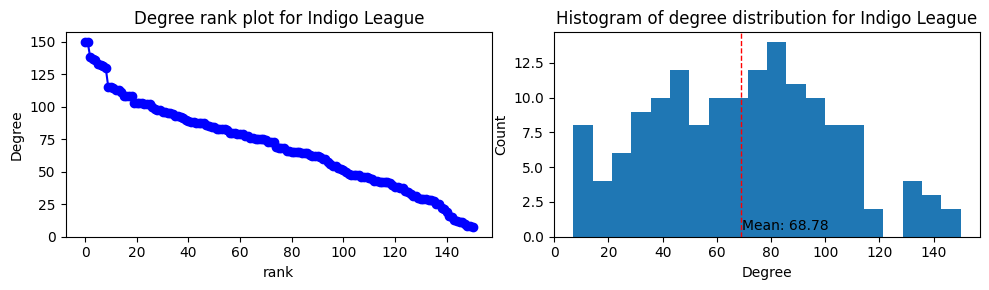

The top ten pokemon with the highest degree are:
Pikachu: 150
Meowth: 150
Pidgeotto: 138
Bulbasaur: 137
Squirtle: 136
Weezing: 133
Charmander: 132
Togepi: 131
Arbok: 130
Starmie: 115
The degree assortativity coefficient is -0.20
The average fraction of neighbors with the same typing as the node itself is 6.56%
The average fraction of neighbors with the same ability as the node itself is 1.56%
The average fraction of neighbors with the same egg group as the node itself is 7.47%
The average fraction of neighbors with the same typing as the node itself when random is 4.82%
The average fraction of neighbors with the same ability as the node itself when random is 1.21%
The average fraction of neighbors with the same egg group as the node itself when random is 6.13%


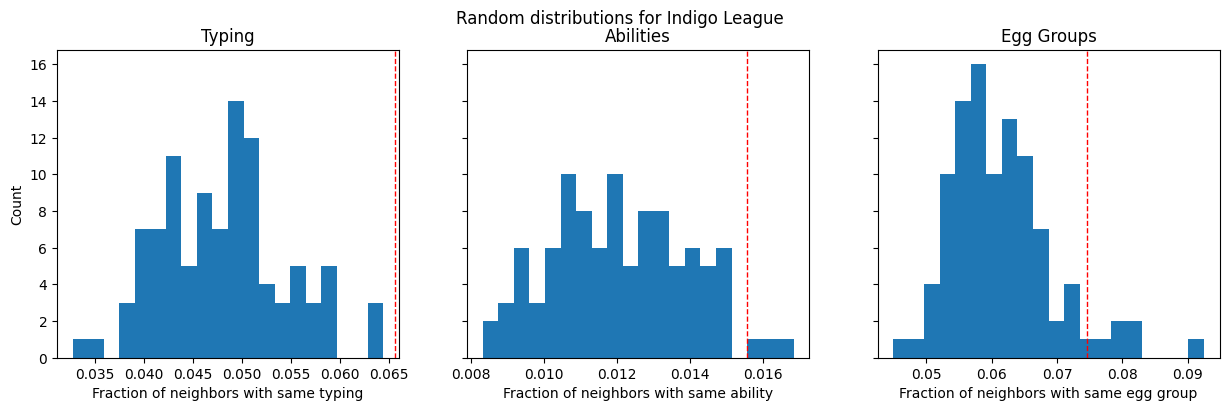

Statistical tests for the three fields:
Typing: 3.365108644960077e-48
Abilities: 2.8434411186421965e-34
Egg Groups: 1.9332695369825403e-31
The modularity is 0.10
There are 4 communities
The community sizes are [49, 40, 33, 29]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Meowth, Pidgeotto, Bulbasaur, Squirtle
Community 2:
Vulpix, Chansey, Charizard, Raticate, Poliwhirl
Community 3:
Oddish, Tauros, Pidgey, Spearow, Voltorb
Community 4:
Krabby, Muk, Persian, Bellsprout, Mewtwo
Testing modularity
Making graph for Johto League season...
Done!
Testing modularity
Making graph for Indigo League season...
Done!
Testing modularity
Making graph for All Seasons season...
Done!
Testing modularity
Making graph for Unova League season...
Done!
Testing modularity
Making graph for Hoenn League season...
Done!
Testing modularity
The average modularity after double edge swap test is 0.08
The p-value for the modularity test is 6.6733998908601694e-62


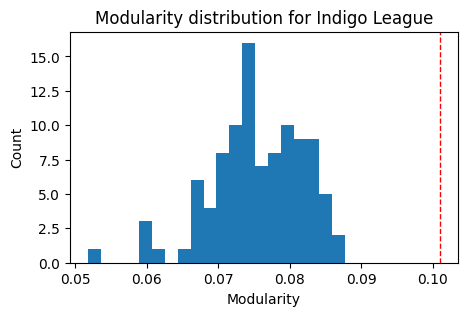

In [26]:
# do graph analysis for indigo
graph_analysis(indigo_df, "indigo", save=False)

Analysing the graph for the Orange Islands season
Making graph for Orange Islands season...
Done!
The graph has 134 nodes and 3399 edges


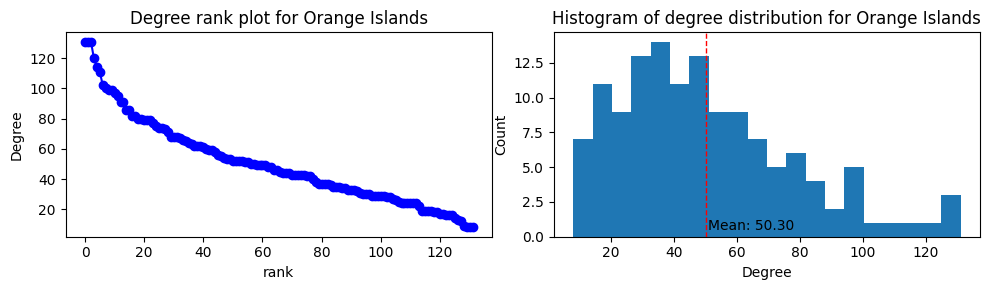

The top ten pokemon with the highest degree are:
Pikachu: 131
Meowth: 131
Togepi: 131
Lapras: 120
Squirtle: 114
Arbok: 111
Weezing: 102
Bulbasaur: 100
Staryu: 99
Victreebel: 99
The degree assortativity coefficient is -0.26
The average fraction of neighbors with the same typing as the node itself is 7.91%
The average fraction of neighbors with the same ability as the node itself is 1.44%
The average fraction of neighbors with the same egg group as the node itself is 8.65%
The average fraction of neighbors with the same typing as the node itself when random is 5.26%
The average fraction of neighbors with the same ability as the node itself when random is 1.30%
The average fraction of neighbors with the same egg group as the node itself when random is 6.25%


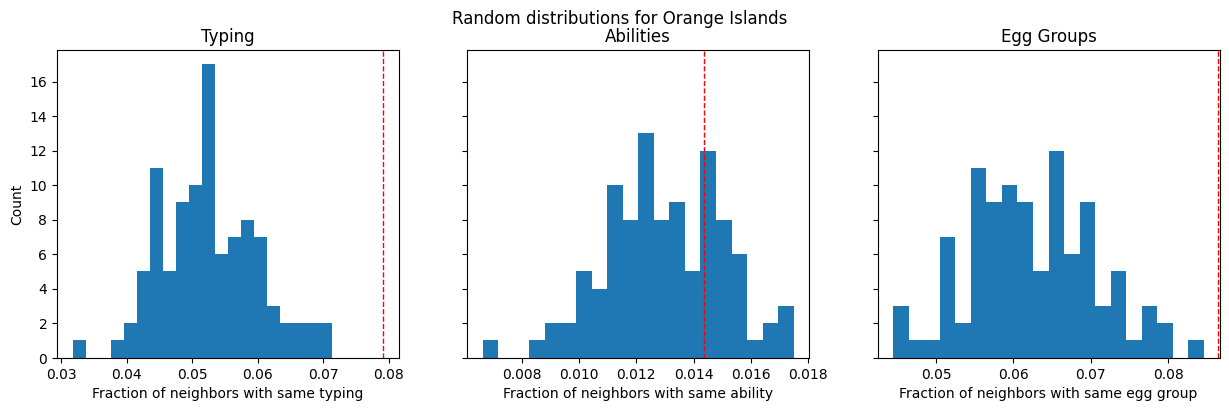

Statistical tests for the three fields:
Typing: 4.0227059372078454e-58
Abilities: 1.7039023110881326e-09
Egg Groups: 6.047942802679532e-51
The modularity is 0.11
There are 5 communities
The community sizes are [26, 38, 18, 20, 30]
The top 5 pokemon in each community are:
Community 1:
Starmie, Magikarp, Kingler, Primeape, Poliwag
Community 2:
Pikachu, Meowth, Togepi, Lapras, Arbok
Community 3:
Mankey, Paras, Caterpie, Pidgey, Exeggutor
Community 4:
Charizard, Electabuzz, Dodrio, Rhydon, Poliwhirl
Community 5:
Squirtle, Bulbasaur, Geodude, Tauros, Jigglypuff
Testing modularity
Making graph for Sinnoh League season...
Done!
Testing modularity
The average modularity after double edge swap test is 0.06
The p-value for the modularity test is 2.993996372656489e-124


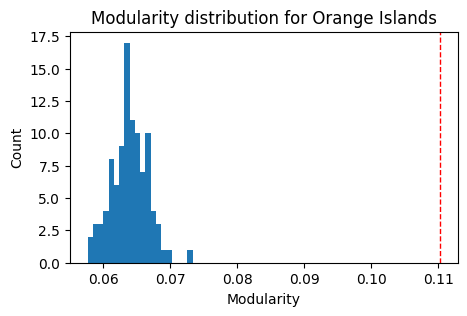

In [27]:
# orange
graph_analysis(orange_df, "orange", save=False)

Analysing the graph for the Johto League season
Making graph for Johto League season...
Done!
The graph has 258 nodes and 10781 edges


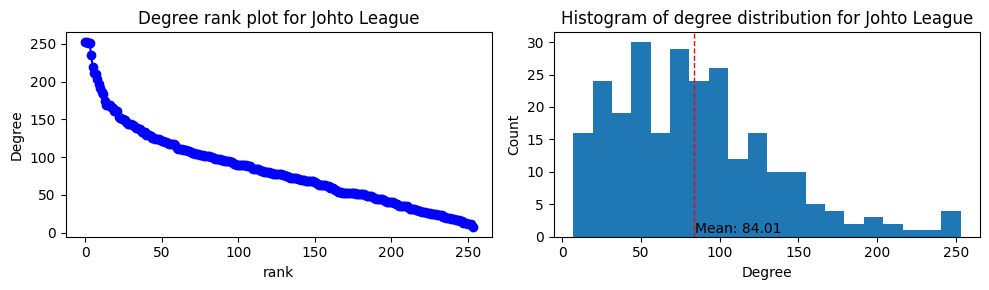

The top ten pokemon with the highest degree are:
Pikachu: 253
Meowth: 253
Togepi: 251
Wobbuffet: 251
Arbok: 235
Noctowl: 220
Weezing: 211
Totodile: 210
Victreebel: 203
Poliwhirl: 197
The degree assortativity coefficient is -0.23
The average fraction of neighbors with the same typing as the node itself is 5.74%
The average fraction of neighbors with the same ability as the node itself is 1.00%
The average fraction of neighbors with the same egg group as the node itself is 8.89%
The average fraction of neighbors with the same typing as the node itself when random is 3.81%
The average fraction of neighbors with the same ability as the node itself when random is 0.73%
The average fraction of neighbors with the same egg group as the node itself when random is 6.74%


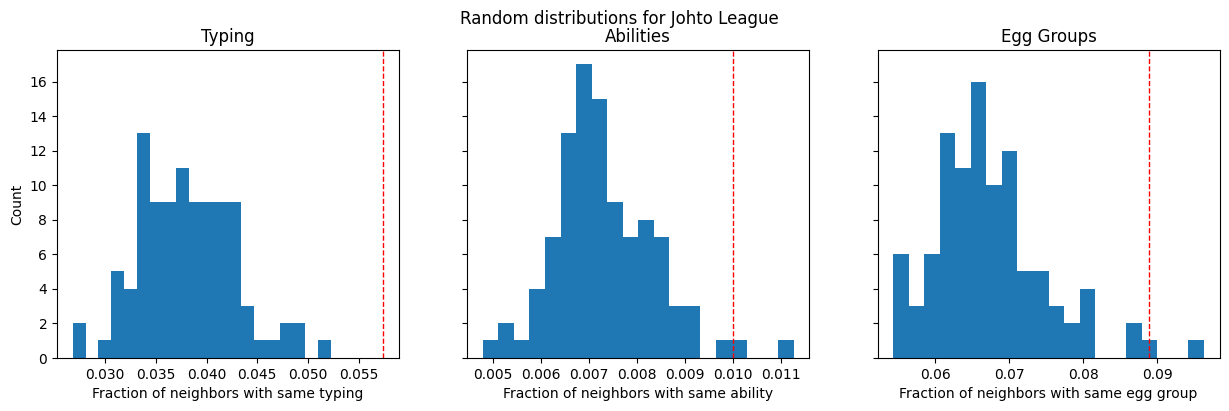

Statistical tests for the three fields:
Typing: 5.142945486629032e-64
Abilities: 4.1356196686632585e-45
Egg Groups: 7.980012857379352e-49
The modularity is 0.11
There are 4 communities
The community sizes are [97, 65, 51, 41]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Meowth, Togepi, Wobbuffet, Arbok
Community 2:
Bellsprout, Chansey, Machoke, Oddish, Quagsire
Community 3:
Charizard, Squirtle, Hitmonchan, Gyarados, Politoed
Community 4:
Poliwhirl, Psyduck, Staryu, Magikarp, Goldeen
Testing modularity
Making graph for Kalos League season...
Done!
Testing modularity
The average modularity after double edge swap test is 0.08
The p-value for the modularity test is 3.953328897082185e-65


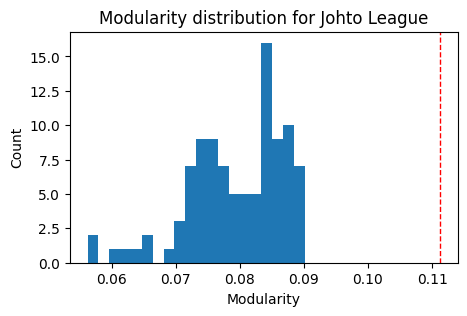

In [28]:
# johto
graph_analysis(johto_df, "johto", save=False)

Analysing the graph for the Hoenn League season
Making graph for Hoenn League season...
Done!
The graph has 366 nodes and 15134 edges


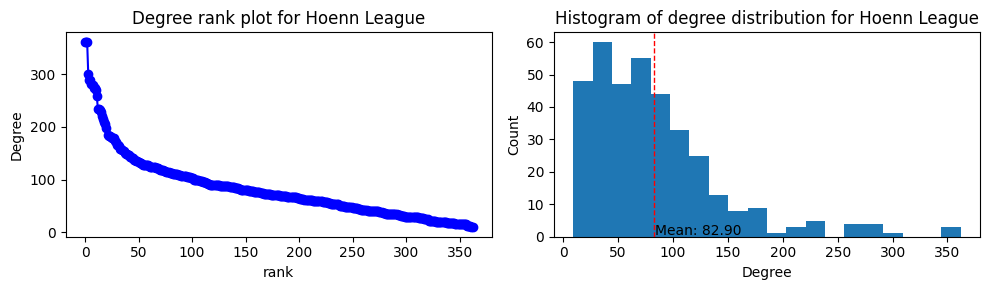

The top ten pokemon with the highest degree are:
Pikachu: 362
Meowth: 362
Wobbuffet: 361
Seviper: 301
Beautifly: 290
Cacnea: 289
Bulbasaur: 281
Chimecho: 279
Mudkip: 273
Skitty: 273
The degree assortativity coefficient is -0.24
The average fraction of neighbors with the same typing as the node itself is 5.57%
The average fraction of neighbors with the same ability as the node itself is 1.10%
The average fraction of neighbors with the same egg group as the node itself is 8.23%
The average fraction of neighbors with the same typing as the node itself when random is 3.38%
The average fraction of neighbors with the same ability as the node itself when random is 0.57%
The average fraction of neighbors with the same egg group as the node itself when random is 6.10%


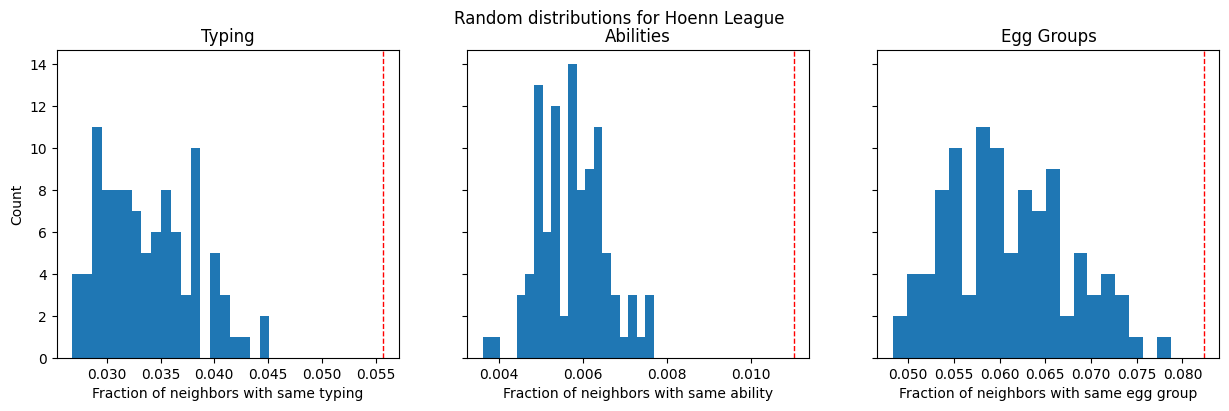

Statistical tests for the three fields:
Typing: 7.334028191611893e-73
Abilities: 7.82140151551271e-84
Egg Groups: 3.0460834022361674e-54
The modularity is 0.16
There are 6 communities
The community sizes are [112, 69, 26, 18, 55, 83]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Meowth, Wobbuffet, Seviper, Beautifly
Community 2:
Bulbasaur, Combusken, Snorunt, Munchlax, Roselia
Community 3:
Tauros, Camerupt, Clefairy, Kirlia, Plusle
Community 4:
Poochyena, Murkrow, Duskull, Flareon, Zubat
Community 5:
Marill, Sunflora, Teddiursa, Oddish, Sandshrew
Community 6:
Chimecho, Torkoal, Grovyle, Swellow, Swampert
Testing modularity
Making graph for Alola League season...
Done!
Testing modularity
The average modularity after double edge swap test is 0.09
The p-value for the modularity test is 2.1161348072240463e-143


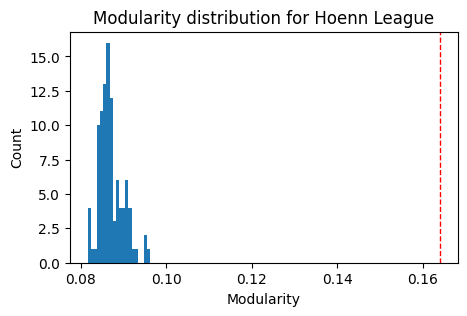

In [29]:
# hoenn
graph_analysis(hoenn_df, "hoenn", save=False)

Analysing the graph for the Sinnoh League season
Making graph for Sinnoh League season...
Done!
The graph has 453 nodes and 20779 edges


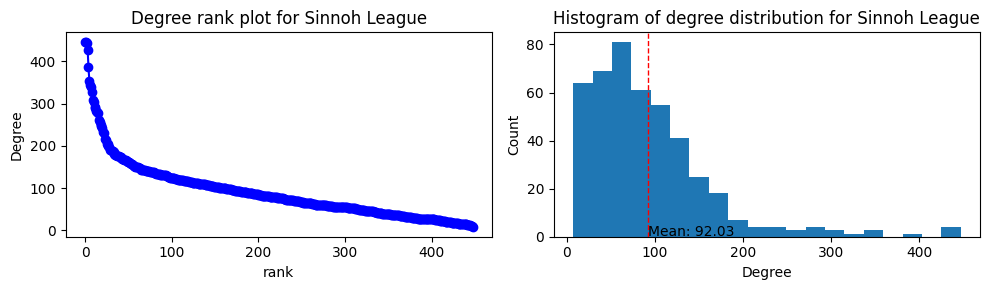

The top ten pokemon with the highest degree are:
Pikachu: 447
Meowth: 447
Piplup: 443
Wobbuffet: 428
Croagunk: 386
Buneary: 353
Seviper: 345
Buizel: 339
Pachirisu: 328
Carnivine: 309
The degree assortativity coefficient is -0.23
The average fraction of neighbors with the same typing as the node itself is 5.74%
The average fraction of neighbors with the same ability as the node itself is 0.94%
The average fraction of neighbors with the same egg group as the node itself is 9.30%
The average fraction of neighbors with the same typing as the node itself when random is 3.42%
The average fraction of neighbors with the same ability as the node itself when random is 0.61%
The average fraction of neighbors with the same egg group as the node itself when random is 6.39%


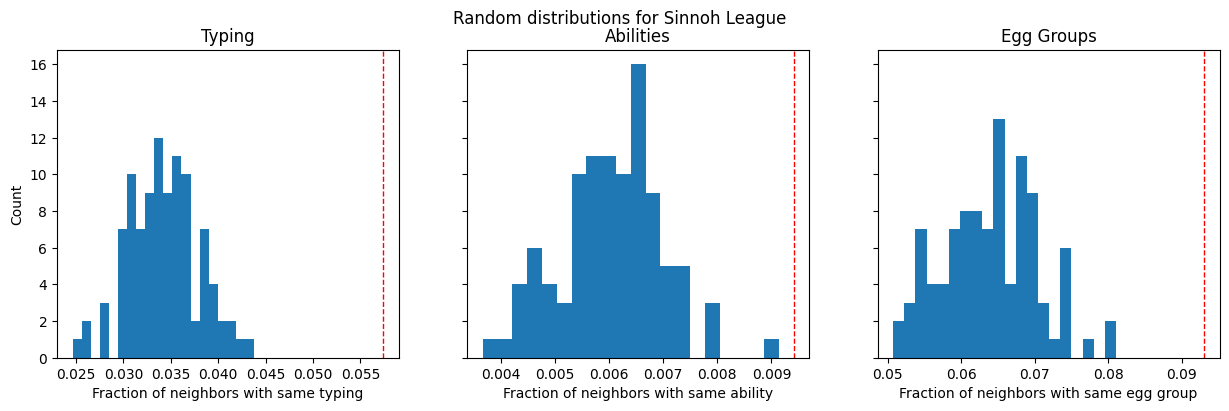

Statistical tests for the three fields:
Typing: 6.607527334053036e-82
Abilities: 1.5107923342069444e-57
Egg Groups: 1.0870130703184112e-67
The modularity is 0.13
There are 6 communities
The community sizes are [97, 21, 74, 90, 131, 35]
The top 5 pokemon in each community are:
Community 1:
Cyndaquil, Sunflora, Teddiursa, Heracross, Snorlax
Community 2:
Palkia, Dialga, Toxicroak, Purugly, Mesprit
Community 3:
Budew, Rattata, Dodrio, Spearow, Growlithe
Community 4:
Glameow, Chansey, Elekid, Shinx, Ursaring
Community 5:
Pikachu, Meowth, Piplup, Wobbuffet, Croagunk
Community 6:
Crawdaunt, Mothim, Alakazam, Goldeen, Natu
Testing modularity
The average modularity after double edge swap test is 0.09
The p-value for the modularity test is 4.7534519507534126e-117


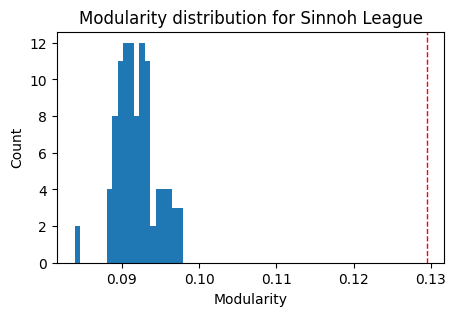

In [30]:
# sinnoh
graph_analysis(diamond_df, "sinnoh", save=False)

Analysing the graph for the Unova League season
Making graph for Unova League season...
Done!
The graph has 324 nodes and 12658 edges


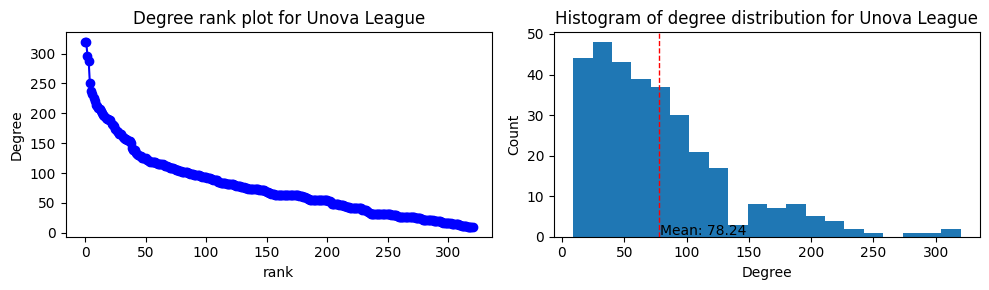

The top ten pokemon with the highest degree are:
Pikachu: 320
Axew: 320
Meowth: 296
Oshawott: 288
Pignite: 250
Pidove: 238
Snivy: 233
Pansage: 225
Deerling: 220
Patrat: 214
The degree assortativity coefficient is -0.25
The average fraction of neighbors with the same typing as the node itself is 4.40%
The average fraction of neighbors with the same ability as the node itself is 0.69%
The average fraction of neighbors with the same egg group as the node itself is 11.44%
The average fraction of neighbors with the same typing as the node itself when random is 3.37%
The average fraction of neighbors with the same ability as the node itself when random is 0.57%
The average fraction of neighbors with the same egg group as the node itself when random is 8.26%


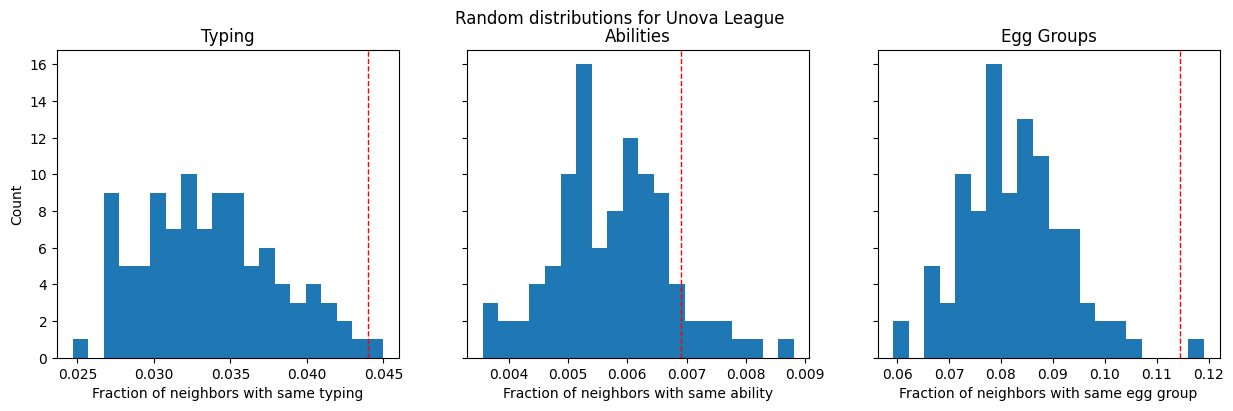

Statistical tests for the three fields:
Typing: 4.1236294917949607e-42
Abilities: 3.724791433452457e-21
Egg Groups: 2.5754826300685622e-54
The modularity is 0.16
There are 5 communities
The community sizes are [81, 88, 36, 52, 64]
The top 5 pokemon in each community are:
Community 1:
Amoonguss, Frillish, Charizard, Boldore, Helioptile
Community 2:
Pikachu, Axew, Meowth, Oshawott, Pignite
Community 3:
Galvantula, Golurk, Seismitoad, Elgyem, Petilil
Community 4:
Watchog, Beartic, Leavanny, Palpitoad, Zebstrika
Community 5:
Pidove, Deerling, Patrat, Swanna, Audino
Testing modularity
The average modularity after double edge swap test is 0.08
The p-value for the modularity test is 1.6139283046377515e-138


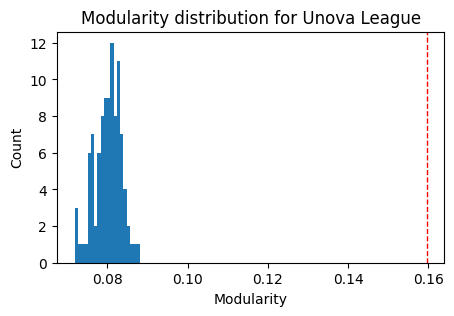

In [31]:
# unova
graph_analysis(black_df, "unova", save=False)

Analysing the graph for the Kalos League season
Making graph for Kalos League season...
Done!
The graph has 439 nodes and 21311 edges


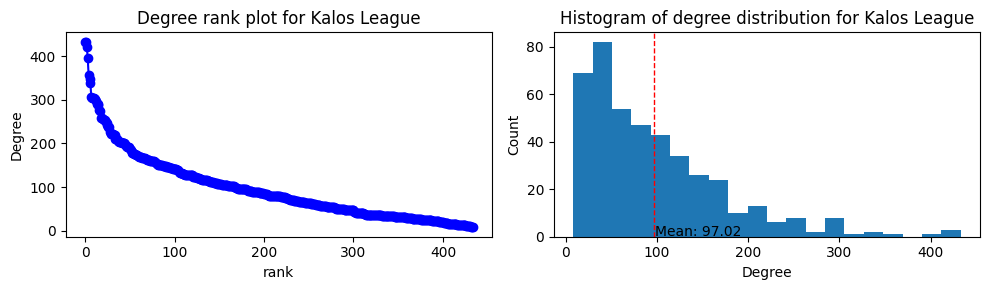

The top ten pokemon with the highest degree are:
Pikachu: 433
Dedenne: 433
Meowth: 420
Wobbuffet: 396
Chespin: 357
Bunnelby: 347
Inkay: 339
Fletchling: 306
Fennekin: 305
Froakie: 304
The degree assortativity coefficient is -0.26
The average fraction of neighbors with the same typing as the node itself is 6.31%
The average fraction of neighbors with the same ability as the node itself is 0.83%
The average fraction of neighbors with the same egg group as the node itself is 9.64%
The average fraction of neighbors with the same typing as the node itself when random is 3.04%
The average fraction of neighbors with the same ability as the node itself when random is 0.51%
The average fraction of neighbors with the same egg group as the node itself when random is 7.00%


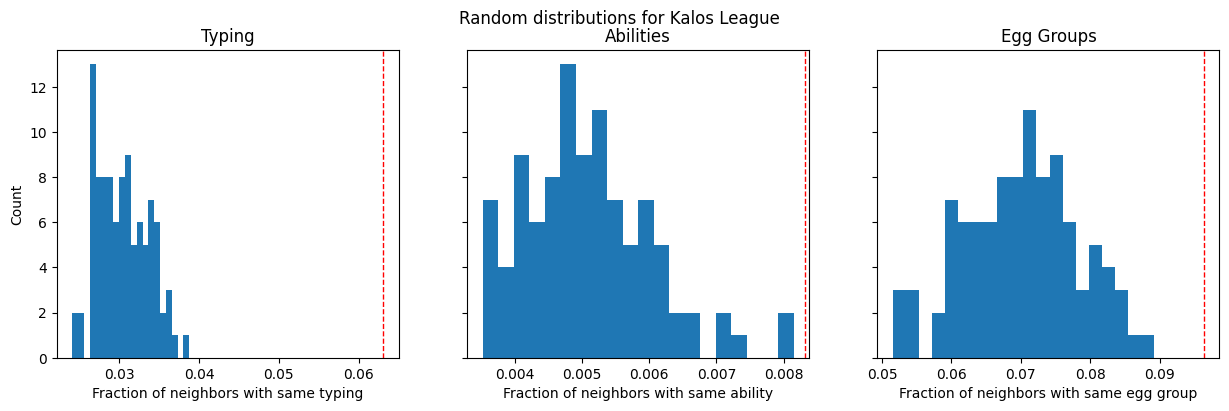

Statistical tests for the three fields:
Typing: 2.026308750522461e-102
Abilities: 2.6376845845842307e-56
Egg Groups: 3.3642691810236074e-54
The modularity is 0.15
There are 4 communities
The community sizes are [174, 80, 74, 106]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Dedenne, Meowth, Wobbuffet, Chespin
Community 2:
Sylveon, Smeargle, Eevee, Furret, Teddiursa
Community 3:
Fletchling, Fennekin, Froakie, Marill, Furfrou
Community 4:
Hoppip, Oddish, Watchog, Sentret, Pachirisu
Testing modularity
Making graph for Orange Islands season...
Done!
Testing modularity
Making graph for Pokémon Journeys season...
Done!
Testing modularity
The average modularity after double edge swap test is 0.09
The p-value for the modularity test is 1.5386689701821878e-116


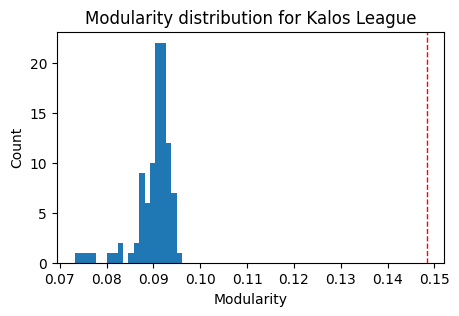

In [32]:
# kalos
graph_analysis(xy_df, "kalos", save=False)

Analysing the graph for the Alola League season
Making graph for Alola League season...
Done!
The graph has 458 nodes and 28784 edges


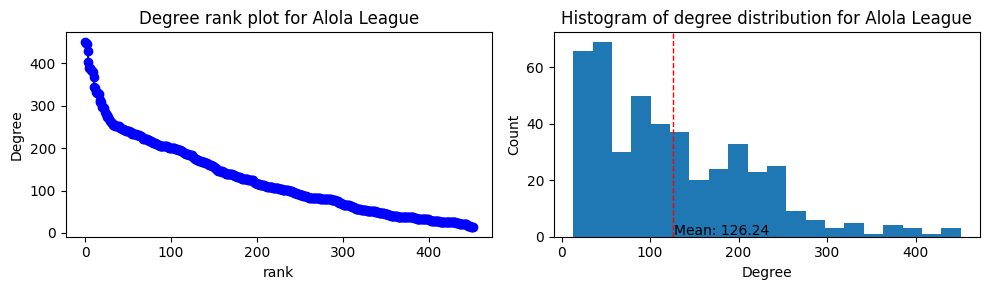

The top ten pokemon with the highest degree are:
Pikachu: 451
Rotom: 448
Togedemaru: 446
Vulpix: 429
Turtonator: 403
Marowak: 390
Popplio: 388
Meowth: 384
Rowlet: 381
Wobbuffet: 379
The degree assortativity coefficient is -0.26
The average fraction of neighbors with the same typing as the node itself is 5.33%
The average fraction of neighbors with the same ability as the node itself is 0.86%
The average fraction of neighbors with the same egg group as the node itself is 9.95%
The average fraction of neighbors with the same typing as the node itself when random is 2.87%
The average fraction of neighbors with the same ability as the node itself when random is 0.46%
The average fraction of neighbors with the same egg group as the node itself when random is 6.81%


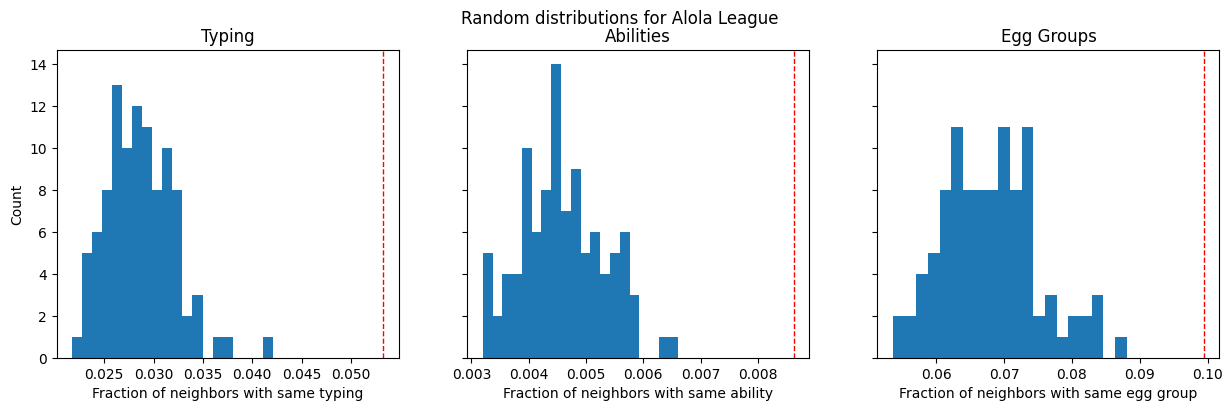

Statistical tests for the three fields:
Typing: 4.841679502522173e-87
Abilities: 6.2529458747427456e-77
Egg Groups: 5.8154158624939253e-67
The modularity is 0.13
There are 5 communities
The community sizes are [154, 87, 91, 46, 74]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Rotom, Togedemaru, Vulpix, Turtonator
Community 2:
Salandit, Yungoos, Raticate, Zubat, Garbodor
Community 3:
Growlithe, Slowpoke, Wingull, Bounsweet, Poliwag
Community 4:
Psyduck, Jigglypuff, Sudowoodo, Comfey, Boldore
Community 5:
Grubbin, Butterfree, Exeggutor, Spearow, Raichu
Testing modularity
The average modularity after double edge swap test is 0.12
The p-value for the modularity test is 7.632469843498626e-17


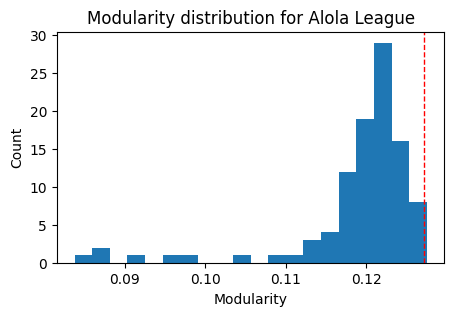

In [33]:
# alola
graph_analysis(sun_df, "alola", save=False)

Analysing the graph for the Pokémon Journeys season
Making graph for Pokémon Journeys season...
Done!
The graph has 698 nodes and 53260 edges


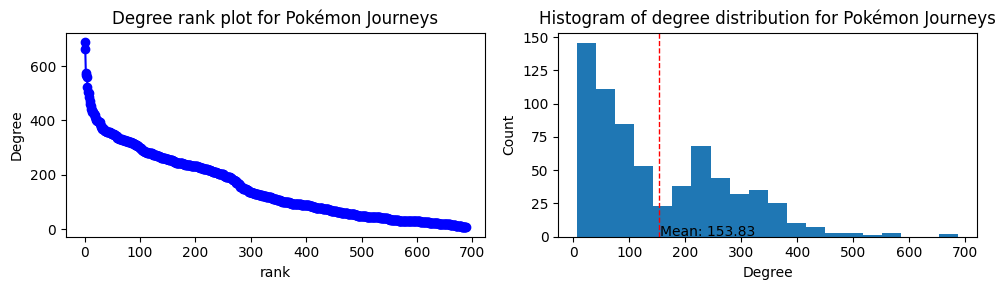

The top ten pokemon with the highest degree are:
Pikachu: 688
Rotom: 663
Meowth: 576
Grookey: 568
Wobbuffet: 560
Cinderace: 523
Lucario: 505
Dragonite: 502
Eevee: 485
Gengar: 473
The degree assortativity coefficient is -0.16
The average fraction of neighbors with the same typing as the node itself is 4.32%
The average fraction of neighbors with the same ability as the node itself is 0.70%
The average fraction of neighbors with the same egg group as the node itself is 8.37%
The average fraction of neighbors with the same typing as the node itself when random is 2.77%
The average fraction of neighbors with the same ability as the node itself when random is 0.34%
The average fraction of neighbors with the same egg group as the node itself when random is 6.71%


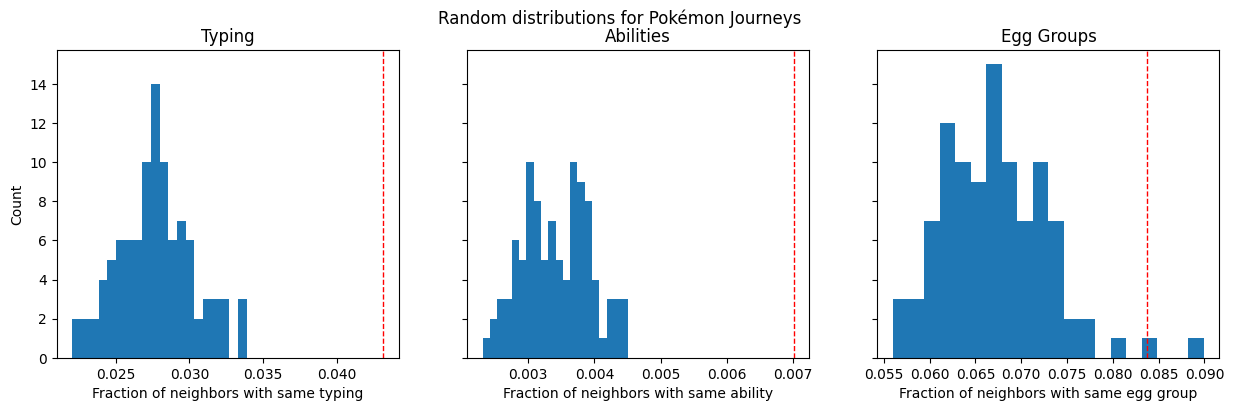

Statistical tests for the three fields:
Typing: 2.889666706999059e-80
Abilities: 1.7425732440549852e-85
Egg Groups: 3.846977339805947e-50
The modularity is 0.18
There are 4 communities
The community sizes are [139, 211, 152, 187]
The top 5 pokemon in each community are:
Community 1:
Yamper, Raboot, Mew, Butterfree, Caterpie
Community 2:
Pikachu, Rotom, Meowth, Grookey, Wobbuffet
Community 3:
Magnemite, Flygon, Raichu, Bellsprout, Boldore
Community 4:
Inteleon, Riolu, Buneary, Pichu, Clefairy
Testing modularity
The average modularity after double edge swap test is 0.06
The p-value for the modularity test is 7.037957005575418e-116


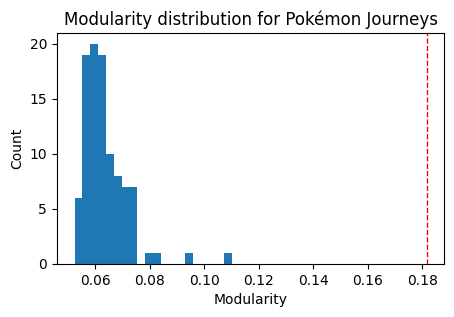

In [34]:
# journeys
graph_analysis(pocket_df, "journeys", save=False)

Analysing the graph for the All Seasons season
Making graph for All Seasons season...
Done!
The graph has 869 nodes and 119010 edges


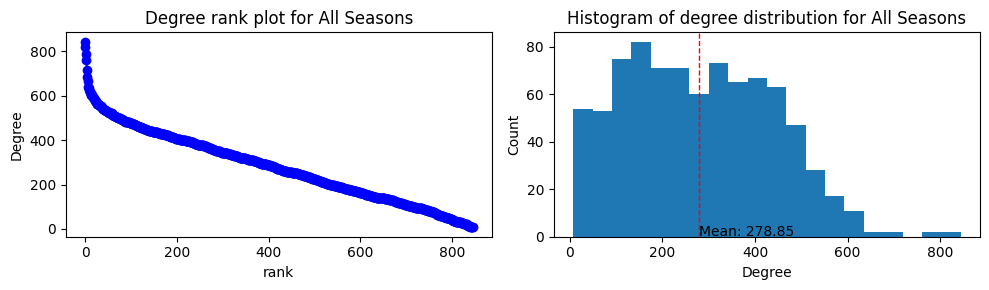

The top ten pokemon with the highest degree are:
Pikachu: 844
Meowth: 821
Wobbuffet: 786
Rotom: 763
Eevee: 716
Charizard: 684
Psyduck: 666
Dragonite: 639
Lucario: 634
Bulbasaur: 626
The degree assortativity coefficient is -0.10
The average fraction of neighbors with the same typing as the node itself is 3.70%
The average fraction of neighbors with the same ability as the node itself is 0.66%
The average fraction of neighbors with the same egg group as the node itself is 8.22%
The average fraction of neighbors with the same typing as the node itself when random is 2.58%
The average fraction of neighbors with the same ability as the node itself when random is 0.34%
The average fraction of neighbors with the same egg group as the node itself when random is 6.76%


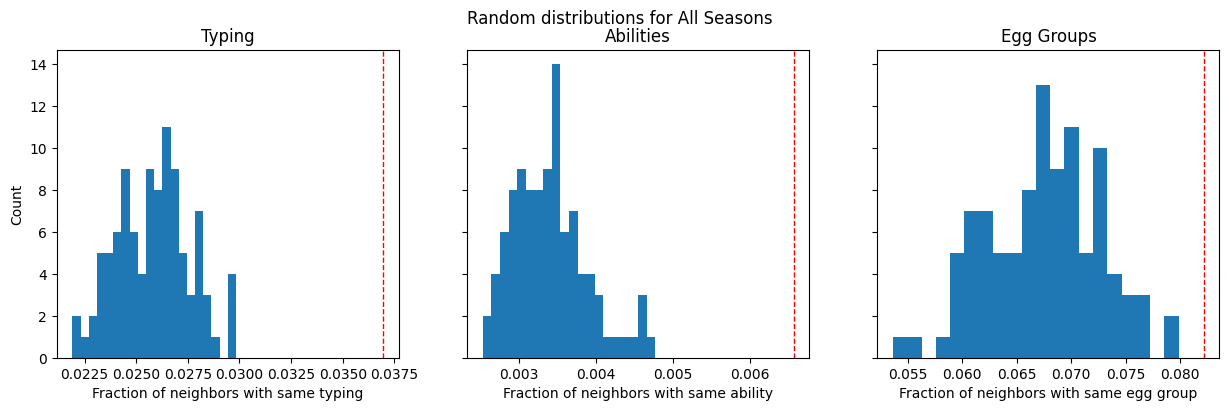

Statistical tests for the three fields:
Typing: 1.565780217488166e-81
Abilities: 1.7081824482493426e-83
Egg Groups: 5.054763704306548e-49
The modularity is 0.22
There are 5 communities
The community sizes are [230, 129, 233, 136, 117]
The top 5 pokemon in each community are:
Community 1:
Pikachu, Meowth, Wobbuffet, Piplup, Skitty
Community 2:
Sandile, Oshawott, Patrat, Scraggy, Lilligant
Community 3:
Psyduck, Dragonite, Bulbasaur, Snorlax, Butterfree
Community 4:
Rotom, Eevee, Charizard, Growlithe, Vulpix
Community 5:
Lucario, Marill, Wooper, Dedenne, Fletchling
Testing modularity


In [35]:
# all seasons
graph_analysis(all_seasons_df, "all_seasons", save=False)

In [36]:
# find which pokemon are in poke_df_clean but not in the graph
# this is to see if there are any pokemon that are not in the graph
# this is not the case
with open(os.path.join("graphs", "all_seasons_G.pkl"), "rb") as f:
    G = pickle.load(f)
non_anime_pokemon = poke_df_clean[~poke_df_clean["pokemon"].isin(G.nodes())][
    "pokemon"
].tolist()

# print the pokemon that are not in the graph
print("The pokemon that are not in any graph are:")
for pokemon in non_anime_pokemon:
    print(pokemon)

The pokemon that are not in any graph are:
Nidoran-f
Nidoran-m
Farfetchd
Mr-mime
Ho-oh
Deoxys-normal
Wormadam-plant
Mime-jr
Porygon-z
Giratina-altered
Shaymin-land
Victini
Basculin-red-striped
Darmanitan-standard
Terrakion
Tornadus-incarnate
Thundurus-incarnate
Landorus-incarnate
Keldeo-ordinary
Meloetta-aria
Flabebe
Meowstic-male
Aegislash-shield
Pumpkaboo-average
Gourgeist-average
Zygarde-50
Oricorio-baile
Lycanroc-midday
Wishiwashi-solo
Type-null
Minior-red-meteor
Mimikyu-disguised
Tapu-koko
Tapu-lele
Tapu-bulu
Tapu-fini
Corvisquire
Blipbug
Boltund
Rolycoly
Carkol
Barraskewda
Toxtricity-amped
Sizzlipede
Polteageist
Sirfetchd
Mr-rime
Eiscue-ice
Indeedee-male
Morpeko-full-belly
Urshifu-single-strike
Glastrier
Spectrier
Calyrex
Wyrdeer
Kleavor
Basculegion-male
Sneasler
Overqwil
Enamorus-incarnate


#### Summary Analysis
This section will attempt to summarise, compare and discuss the results from each analysis done above.

***Graph Sizes***

Let's first get a brief look at the sizes of the graphs.

- Indigo League: 153 nodes and 5250 edges.

- Orange Islands: 134 nodes and 3399 edges.

- Johto League: 258 nodes and 10781 edges.

- Hoenn League: 366 nodes and 15134 edges.

- Sinnoh League: 453 nodes and 20779 edges.

- Unova League: 324 nodes and 12658 edges.

- Kalos League: 439 nodes and 21311 edges.

- Alola League: 458 nodes and 28784 edges.

- Pokémon Journeys: 698 nodes and 53260 edges.

- All Seasons: 869 nodes and 119010 edges.

What is shown from somethign as simple as the graph sizes is that obviously the graphs grow from season to season especially in the first couple of seasons. This aligns very well with the fact that the Pokémon anime is based off of the Pokémon video game. In this game series, new Pokémon are added to each iteration of the game, and hence, one would expect the number of Pokémon to increase with each released season. However, at one point, decisions were made to not include all previous Pokémon in the next iteration of the game, and this happened some point between the Unova League and the Kalos League. This might explain why the number of nodes stopped stopped increasing around this point. 

Also, it is interesting to note that although there were 905 Pokémon left in the dataframe containing all Pokémon, the network of all seasons only has 869 nodes. This should mean that 36 Pokémon do not appear in the show at all. However, the more obvious reason as to why this has happened is due to discrepancies between the names from PokéAPI and Bulbapedia. In the code cell above, the names of these mysterious Pokémon have been printed, and a clear pattern emerges. Some Pokémon have some sort of description after their names such as "Pumpkaboo-average" which will not match the "Pumpkaboo" name found from Bulbapedia. Whilst this is a shame, it has only happened in a small amount of cases, and therefore the impact is assumed to be minimal. Some of these Pokémon are also known as legendary Pokémon, and these are quite rare to appear in the anime episodes as well.

***Degree Analyses***

Let's summarise each of the degree analyses. This will be done very briefly.

- Indigo League: The top 5 Pokémon w.r.t. degree are Pikachu: 150, Meowth: 150, Pidgeotto: 138, Bulbasaur: 137, Squirtle: 136. The distribution of degrees appear pretty uniform, and the degree rank plot shows linear tendenies. The degree assortativity coefficient is at -0.20.

- Orange Islands: he top 5 Pokémon w.r.t. degree are Pikachu: 131, Meowth: 131, Togepi: 131, Lapras: 120, Squirtle: 114. Not as uniform as for Indigo League, almost appears normally distributed with some nodes having large degrees but with most lying between ~10 and ~90. The degree assortativity coefficient is -0.26.

- Johto League: Top 5 Pokémon are Pikachu: 253, Meowth: 253, Togepi: 251, Wobbuffet: 251, Arbok: 235. Resembles Orange Islands, almost appears normally distributed, however some tendency to be heavy-tailed with few nodes having very high degrees. Degree assortativity coefficient of -0.23.

- Hoenn League: Top 5 Pokémon are Pikachu: 362, Meowth: 362, Wobbuffet: 361, Seviper: 301, Beautifly: 290. Mostly resembles heavy-tailed distribution with very few nodes having large degrees and most nodes clumped. Degree assortativity coefficient of -0.24.

- Sinnoh League: Top 5 Pokémon are Pikachu: 447, Meowth: 447, Piplup: 443, Wobbuffet: 428, Croagunk: 386. Degree histogram also shows heavy-tailed distribution with many nodes having small degrees compared to the few nodes having large degree values. Degree assortativity coefficient of -0.23.

- Unova League: Top 5 Pokémon are Pikachu: 320, Axew: 320, Meowth: 296, Oshawott: 288, Pignite: 250. Histogram shows trend of many nodes having smaller degree and very few nodes with large degree. Heavy-tailed distribution. Degree assortativity coefficient of -0.25.

- Kalos League: Top 5 Pokémon are Pikachu: 433, Dedenne: 433, Meowth: 420, Wobbuffet: 396, Chespin: 357. Again, heavy-tailed distribution shown in histogram plot. Degree assortativity coefficient of -0.26.

- Alola League: Top 5 Pokémon are Pikachu: 451, Rotom: 448, Togedemaru: 446, Vulpix: 429, Turtonator: 403. Histogram shows heavy-tailed distribution. Degree assortativity coefficient of -0.26.

- Pokémon Journeys: Top 5 Pokémon are Pikachu: 688, Rotom: 663, Meowth: 576, Grookey: 568, Wobbuffet: 560. Interesting distribution plot in histogram. Many nodes with small degree, then a decently sized group with degrees around ~160 to ~350, and finally very few nodes with larger degrees. Degree assortativity coefficient of -0.16.

- All Seasons: Top 5 Pokémon are Pikachu: 844, Meowth: 821, Wobbuffet: 786, Rotom: 763, Eevee: 716. Very interesting distribution. Select group of Pokémon with very large degree values, and many others with very spread out degree values. Degree assortativity coefficient of -0.10.

Interesting development from season to season w.r.t top Pokémon, degree distributions and degree assortativity coefficients. First of all, the Pokémon animes favourite character is obviously Pikachu that appears together in an episode with almost every other Pokémon in existence. This makes good sense since Pikachu is the companion of Ash, the shows protagonist, who appears in every season of the show. It is then important to note the other top Pokémon such as Meowth, Wobbuffet, and several others. The Pokémon anime has two main anagonists being the two Team Rocket members Jesse and James. These two has a number of companions being exactly the Pokémon Meowth, Wobbuffet, and Arbok/Seviper with Seviper being the evolution of Arbok. The other top Pokémon often belong to either Ash acting as his team throughout his journey or they belong to the sidekicks of each season. A good example of this is Axew from Season 6 (Unova League) who is the main Pokémon of the sidekick Iris. 

W.r.t. the degree distributions of each season, the first couple of seasons do not exactly show signs of being heavy-tailed. The hypothesis for this is that there are simply not enough Pokémon yet, and since the show was kind of new, the showrunners would prefer to give a decent amount of airtime to each Pokémon in the show. However, as the number of Pokémon grew, and fan-favourites developed amongst fans, the degree distribution changed accordingly. Also, since the number of Pokémon grew, it was perhaps not possible to include as many Pokémon as possible in each episode without either heavily increasing the amount of episodes or increasing the runtime of each episodes both of which seam infeasible. As such, it makes sense to prioritize more airtime for more popular Pokémon, and this is the hypothesis as to why the degree distributions have evolved as shown in the analyses above.

Looking at the degree assortativity coefficient across seasons, there is a pattern of all seasons having negative values for this measure with the largest being -0.26 (Orange Islands, Kalos League, and Alola League) and the smallest being -0.10 (All Seasons). As such, there exists a pattern across all seasons for Pokémon with large degrees being more likely to be connected to Pokémon of smaller degrees, and vice-versa. The hypothesis for this is that the main Pokémon will obviously appear in many episodes, and thus appear in the same episodes as many other Pokémon. On the contrary, more niche Pokémon will not have as much airtime, and not appear in as many episodes. As such, it is more rare for niche Pokémon to appear in the same episode than it is for popular Pokémon. Hence, the reason for the degree assortativity coefficient being negative is an effect of all the niche Pokémon with little airtime having many connections to the popular Pokémon that appear in every episodes.  

***Attribute Analyses***

Note, all statistical tests will operate with a significance level of 0.05.

- Indigo League: Obvious for all three attributes, that there is some correlation between Pokémon that has an edge between them and their attributes. This is both seen in the plots as well as in the statistical test with p-values well below the chosen significance level.

- Orange Islands: As for Indigo League network, there is correlation between Pokémon that has an edge between them and their attributes.

- Johto League: Obvious correlation between Pokémon that has an edge between them and their attributes.

- Hoenn League: Obvious correlation between Pokémon that has an edge between them and their attributes.

- Sinnoh League: Obvious correlation between Pokémon that has an edge between them and their attributes.

- Unova League: Obvious correlation between Pokémon that has an edge between them and their attributes.

- Kalos League: Obvious correlation between Pokémon that has an edge between them and their attributes.

- Alola League: Obvious correlation between Pokémon that has an edge between them and their attributes.

- Pokémon Journeys: Obvious correlation between Pokémon that has an edge between them and their attributes.

- All Seasons: Obvious correlation between Pokémon that has an edge between them and their attributes.

What is the result of this analysis is that there exist evidence of correlation between which Pokémon have an edge between them, and their attributes. This is true in all seasons of the Pokémon show, albeit with some variations in the p-values (whilst all are still far, far lower than the significance level). The question is then, if this makes sense. The reason for this being true might be something as simple as the concept of Pokémon families and evolution lines. It is true that Pokémon from the same evolution line will more often than not share the same types, abilities and egg groups. Hence, the reason behind the results shown from the analysis is that when one Pokémon from an evolution line appears in an episodes it evolutions will also appear. This also makes some intuitive sense just as in real life such that Pokémon are likely to stick together in groups or packs with some being further older/more evolved than others. However, whether this is true or not would require further testing, and is currently outside the scope of this project.

***Community & Modularity Analyses***

- Indigo League: 4 communities with sizes [29, 45, 45, 32]. The modularity for this partitioning is 0.1, and this is found to be significantly different than the average modularity of 0.07 when links between nodes are shuffled.

- Orange Islands: 5 communites with sizes [28, 32, 17, 35, 20]. Modularity of 0.11. Double edge swap yields average modularity of 0.07. Significant difference.

- Johto League: 4 communities with sizes [88, 77, 39, 50]. Modularity of 0.11. Double edge swap yields average modularity of 0.08. Significant difference.

- Hoenn League: 5 communities with sizes [122, 22, 54, 91, 74]. Modularity of 0.16, and double edge swap yields average modularity of 0.09. Significant difference.

- Sinnoh League: 5 communities with sizes [152, 111, 49, 73, 63]. Modularity of 0.14, and double edge swap yields average modularity of 0.09. Significant difference.

- Unova League: 4 communities with sizes [88, 112, 19, 102]. Modularity of 0.16, and double edge swap yields average modularity of 0.08. Significant difference.

- Kalos League: 4 communities with sizes [88, 112, 19, 102]. Modularity of 0.16, and double edge swap yields average modularity of 0.08. Significant difference.

- Alola League: 5 communities with sizes [164, 86, 94, 43, 65]. Modularity of 0.13, and double edge swap yields average modularity of 0.12. Significant difference.

- Pokémon Journeys: 4 communities with sizes [208, 303, 156, 22]. Modularity of 0.19, and double edge swap yields average modularity of 0.07. Significant difference.

- All Seasons: 5 communities with sizes [208, 132, 249, 138, 118]. Modularity of 0.21, however, double edge swap was infeasible to perform due to the number of edges in this graph. This is unfortunate.

The final part of the graph analyses covers the community and modularity aspect of the networks. In all the networks, the modularity of these networks are found to be above 0 indicating some slight community structure in the graphs. However, in all cases the partitionings appear to be sub-optimal, and perhaps it does not make sense to separate the nodes into different communities based off of this analysis. From the double edge swap test, trying to determine whether the modularity is random or not, it is shown that the modularity is indeed not random in any of the cases. The question is then, what is the cause of this modularity, and can it be explained? To answer this question, it might make sense to draw on the point raised before about Pokémon families and evolution lines. Hence, some of these communities might exist due to some Pokémon species living in different habitats than others such as in water, forests, caves, etc. Since episodes in the Pokémon anime are rather short, the characters are likely to spend the entire time in one habitat with certain types of Pokémon living there. However, there will certainly exist overlaps in these habitats, as is true for animals in the real world. Whether or not this is the reason for the partitionings is not entirely certain, though, and would require more analysis beyond the scope of this project.

Also note that the network with the largest value of modularity is the network covering all seasons, and this intuitively makes perfect sense. Just as different Pokémon live in different habitats, different Pokémon also live in different regions, and since almost every Pokémon season takes place in a different region, this would explain why the community structure is stronger when looking at all seasons at once. The hypothesis is therefore, that the communities themselves represent regional differences, however, further analysis would be required to determine whether this is true or not. 

This concludes the full network analysis.

### Text Analysis
The following section will contain all steps to the text analysis

#### Define required downloads

In [4]:
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jonashoffmann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonashoffmann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/jonashoffmann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Define the seasons as a dict
By defining each season to its corresponding dataframe, we can get a proper name corresponding to the data.

In [5]:
season_to_episodes_df = {
    "Indigo League": "indigo_df.pkl",
    "Orange Islands": "orange_df.pkl",
    "Johto League": "johto_df.pkl",
    "Pokémon Journeys": "pocket_monsters.pkl",
    "Hoenn League": "hoenn_df.pkl",
    "Kalos League": "xy_df.pkl",
    "Unova League": "black_df.pkl",
    "Alola League": "sun_df.pkl",
    "Sinnoh League": "diamond_df.pkl",
}

season_to_graph_paths = {
    "Indigo League": "indigo_G.pkl",
    "Orange Islands": "orange_G.pkl",
    "Johto League": "johto_G.pkl",
    "Pokémon Journeys": "journeys_G.pkl",
    "Hoenn League": "hoenn_G.pkl",
    "Kalos League": "kalos_G.pkl",
    "Unova League": "unova_G.pkl",
    "Alola League": "alola_G.pkl",
    "Sinnoh League": "sinnoh_G.pkl",
    "All seasons": "all_seasons_G.pkl",
}

#### Load and combine the data
We are going to create a large dataframe, with an added season column, such that it is easier to analyze the data.

In [6]:
season_to_dfs = {k: pd.read_pickle(v) for k, v in season_to_episodes_df.items()}

# Add the season column
for season, df in season_to_dfs.items():
    df["season"] = season

# Create the combined dataframe
all_df = pd.concat(season_to_dfs.values(), ignore_index=True)

print("Total number of episodes:", len(all_df))
all_df.head()

Total number of episodes: 1173


,pokemon,plot,season
0,"[Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...",Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...,Indigo League
1,"[Goldeen, Pikachu, Rattata, Jigglypuff, Caterp...",Ash rushes into Viridian City with his gravely...,Indigo League
2,"[Pikachu, Caterpie, Beedrill, Ekans, Pidgeotto...",Ash discovers and catches a Caterpie—his first...,Indigo League
3,"[Pikachu, Bulbasaur, Charmander, Beedrill, Pin...",Misty and Ash continue to wander the Viridian ...,Indigo League
4,"[Geodude, Pikachu, Pidgeotto, Meowth, Butterfr...","Jessie, James, and Meowth dig a trap for our h...",Indigo League


#### Preliminary analysis of seasons
Here we are going to create a bar plot of the number of episodes per season.

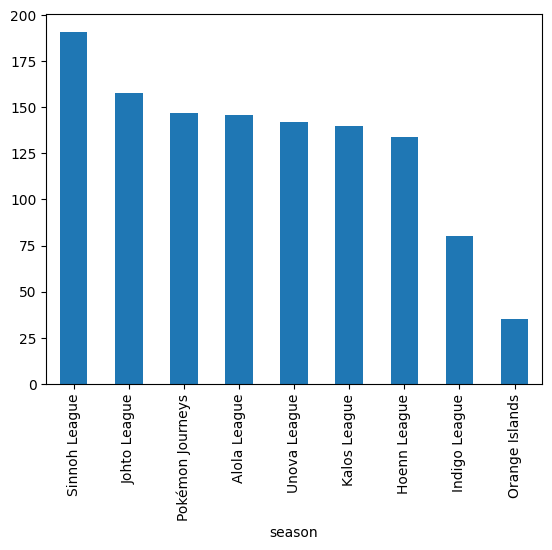

In [7]:
plt.figure()
season_counts = all_df["season"].value_counts()
season_counts.plot.bar()
plt.show()

#### Load the graph for the anime

In [8]:
season_to_graphs = {}
for season, path in season_to_graph_paths.items():
    with open(f"graphs/{path}", "rb") as f:
        season_to_graphs[season] = pickle.load(f)

for season, graph in season_to_graphs.items():
    print(f"{season}:")
    print("Number of nodes:", len(graph.nodes()))
    print("Number of edges:", len(graph.edges()))
    print()

Indigo League:
Number of nodes: 151
Number of edges: 5193

Orange Islands:
Number of nodes: 132
Number of edges: 3320

Johto League:
Number of nodes: 254
Number of edges: 10669

Pokémon Journeys:
Number of nodes: 689
Number of edges: 52993

Hoenn League:
Number of nodes: 363
Number of edges: 15046

Kalos League:
Number of nodes: 434
Number of edges: 21053

Unova League:
Number of nodes: 321
Number of edges: 12558

Alola League:
Number of nodes: 452
Number of edges: 28531

Sinnoh League:
Number of nodes: 448
Number of edges: 20615

All seasons:
Number of nodes: 845
Number of edges: 117813



#### Create a dataframe with the pokemon and their communities with a season column
Load the pokemon communities and create a dataframe with the pokemon and their communities.

In [9]:
season_to_pokemon_communities = {}
for season, graph in season_to_graphs.items():
    nodes = graph.nodes(data=True)
    season_to_pokemon_communities[season] = pd.DataFrame(
        [[pokemon, data["group"], season] for pokemon, data in nodes],
        columns=["pokemon", "community", "season"],
    )

# Combine the dataframes
all_pokemon_communities_df = pd.concat(
    season_to_pokemon_communities.values(), ignore_index=True
)

print("Total number of pokemon (non-unique):", len(all_pokemon_communities_df))
all_pokemon_communities_df

Total number of pokemon (non-unique): 4089


,pokemon,community,season
0,Pikachu,0,Indigo League
1,Mankey,1,Indigo League
2,Spearow,2,Indigo League
3,Gyarados,0,Indigo League
4,Nidorino,2,Indigo League
...,...,...,...
4084,Dubwool,2,All seasons
4085,Perrserker,2,All seasons
4086,Flapple,4,All seasons
4087,Hatenna,1,All seasons


#### Create the tokenizer
We are going to create a tokenizer that will tokenize the text, remove stopwords, such that we can get a better understanding of the words used in the plot.

The steps we are going to do are as follows:
1. Split into word tokens with NLTK
2. Convert all tokens to lowercase
3. Remove all punctuation and other special characters
4. Remove all numbers/digits
5. Remove spaces
6. Convert all characters to ascii characters to remove all japanese and otherwise special characters
7. Remove all stopwords

This tokenizer makes sure, that we have all the words in same format. Moreover, it seems that in the text that there is quite a lot of Japanese spread throughout, and to combat that (since we cannot analyse Japanese text), we convert all the text to ASCII, which only has A-Z. This makes sure, that we get understandable collocations, wordclouds etc.

In [10]:
import unicodedata
from typing import Optional, Callable


def get_tokenizer(
    stopwords: set[str], lemmatizer: Optional[nltk.WordNetLemmatizer] = None
) -> Callable:
    def tokenizer(text: str) -> str:
        # Split the text into words
        word_tokens = nltk.word_tokenize(text)

        # Lower all words
        word_tokens = [word.lower() for word in word_tokens]

        # Remove all punctuation and other special signs
        word_tokens = [re.sub("[.,!?:;-='...'@#_]", " ", s) for s in word_tokens]

        # Remove all numbers
        word_tokens = [re.sub(r"\d+", "", w) for w in word_tokens]

        # Make sure the remove all unneccessary speaces
        word_tokens = [word.strip() for word in word_tokens if word not in stopwords]

        # Remove all accents and special characters and convert it to ascii
        word_tokens = [
            unicodedata.normalize("NFKD", word)
            .encode("ascii", "ignore")
            .decode("utf-8")
            for word in word_tokens
        ]

        # Then remove all stopwords
        tokens = [
            word for word in word_tokens if word.isalpha() and word not in stopwords
        ]

        # Then lemmatize the words
        if lemmatizer is not None:
            tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return tokens

    return tokenizer

In [11]:
stopwords = set(nltk.corpus.stopwords.words("english"))
tokenizer = get_tokenizer(stopwords)

all_df["tokens"] = Parallel(n_jobs=-1)(
    delayed(tokenizer)(plot) for plot in tqdm(all_df["plot"])
)

  0%|          | 0/1173 [00:00<?, ?it/s]

#### Create a dataframe with the tokens and the season
Here we are creating a dictionary mapping from season (including a mapping of all seasons) to the tokens used in the plot.

In [12]:
season_names = list(season_to_dfs.keys()) + ["All seasons"]  # Add all seasons
season_to_tokens = {}
for season in season_names:
    if season == "All seasons":
        season_to_tokens[season] = all_df["tokens"].sum()
    else:
        season_to_tokens[season] = all_df[all_df["season"] == season]["tokens"].sum()

# number of unique tokens per season
for season, tokens in season_to_tokens.items():
    print(f"{season}: {len(set(tokens))}")

Indigo League: 6301
Orange Islands: 3548
Johto League: 8958
Pokémon Journeys: 8501
Hoenn League: 8505
Kalos League: 7939
Unova League: 8988
Alola League: 8365
Sinnoh League: 9777
All seasons: 20998


#### Plot the ZIPF distribution for each season

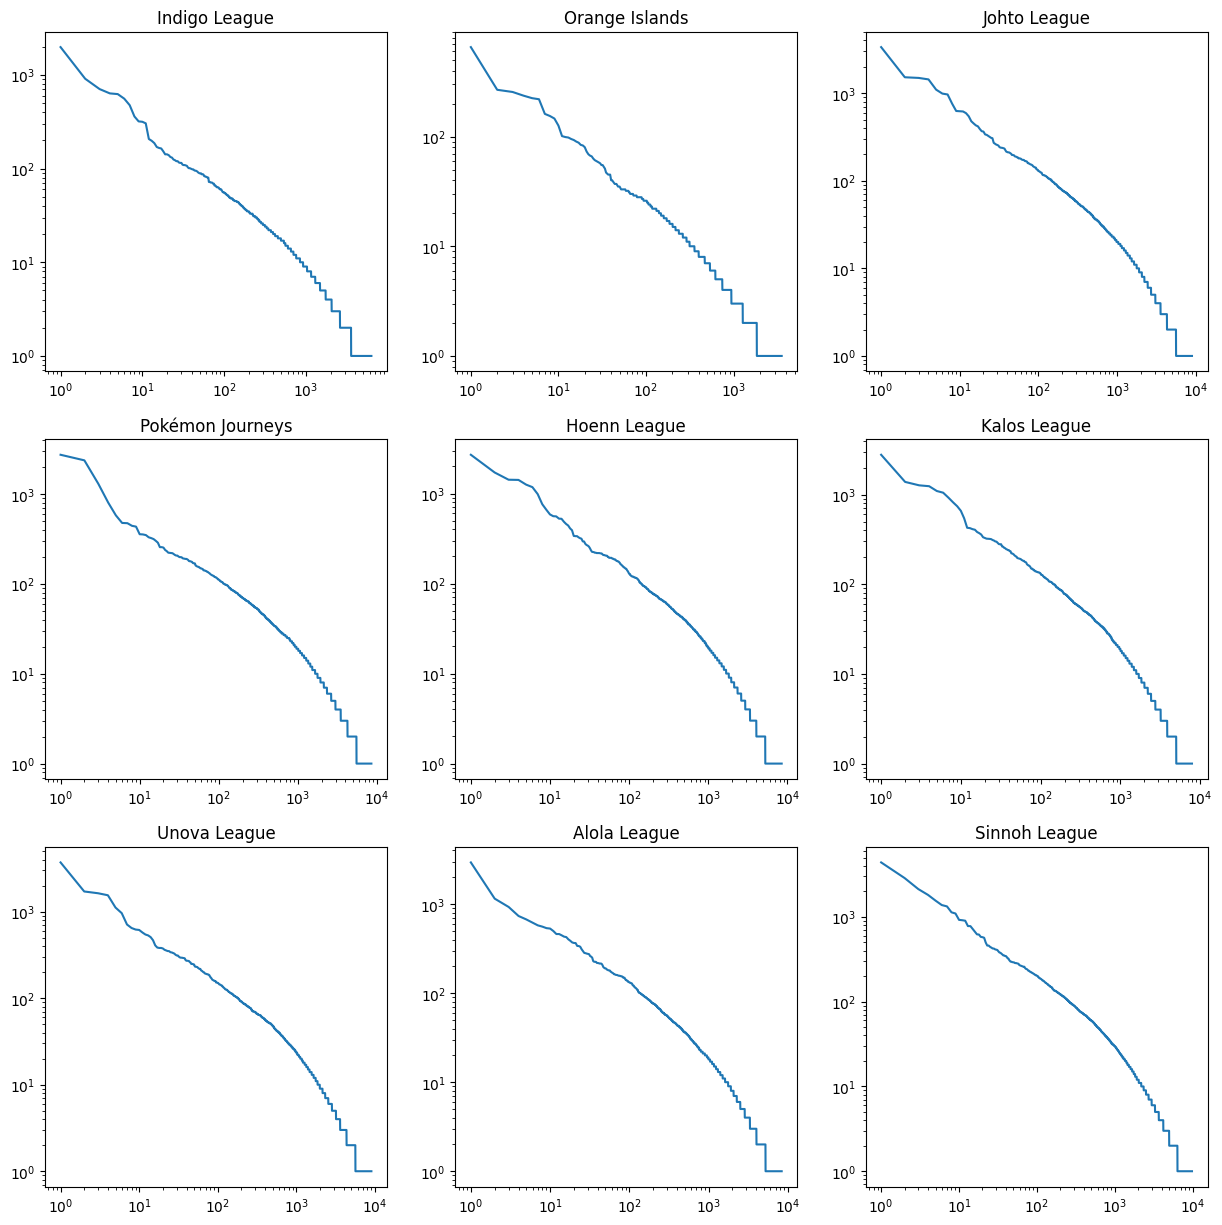

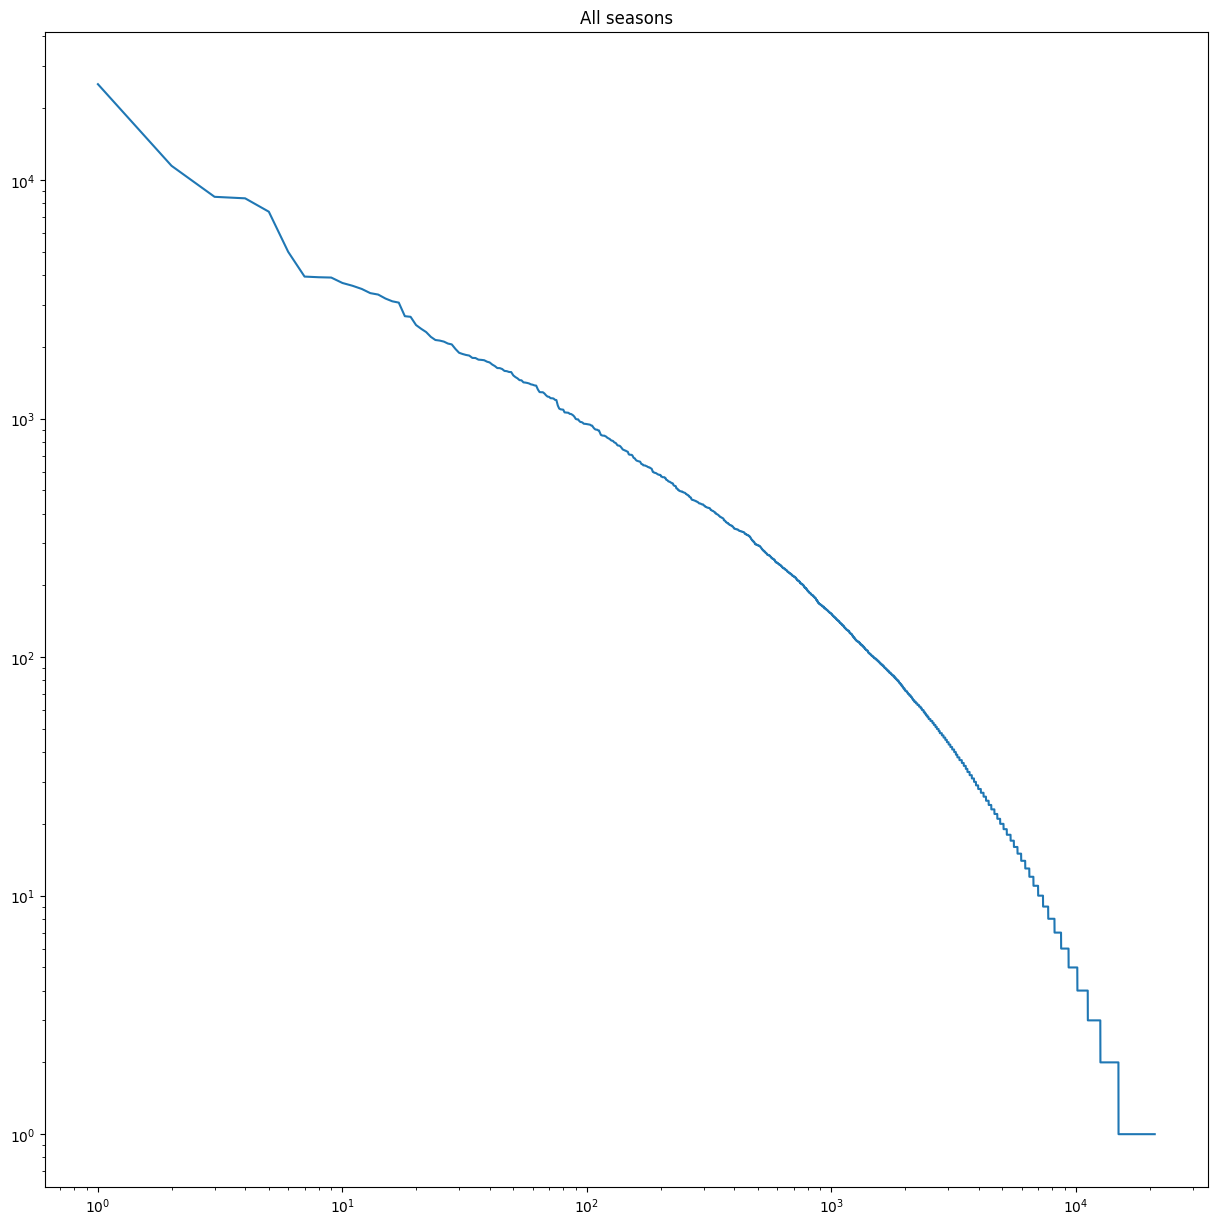

In [13]:
def plot_zipf(tokens, ax):
    fdist = nltk.FreqDist(tokens)
    most_common = fdist.most_common()

    x = np.arange(1, len(most_common) + 1)
    y = [freq for word, freq in most_common]

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(x, y)


# Plot the ZIPF distribution for each season in a grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, season in enumerate(season_names[:-1]):
    ax = axs[i // 3, i % 3]
    ax.set_title(season)
    plot_zipf(season_to_tokens[season], ax=ax)
plt.show()
os.makedirs("zipf", exist_ok=True)
fig.savefig("zipf/per_season.png")

# Plot the ZIPF distribution for all seasons
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("All seasons")
plot_zipf(season_to_tokens["All seasons"], ax=ax)
plt.show()
fig.savefig("zipf/all.png")

As one can see in the plots above, all the token frequencies of the individual seasons and the combined _All seasons_ follow Zipf's law quite well. They all seem to follow a power law distribution.

#### Create the bigrams for each season
Bigrams are pairs of words that are next to each other in the text. We are going to create a list of bigrams for each season. Then we are going to sum all the tokens for each season, such that we can use it to create contingency tables later.

In [14]:
def get_bigrams(tokens):
    return list(nltk.bigrams(tokens))


# Set the bigrams for the dataframe
all_df["bigrams"] = [get_bigrams(tokens) for tokens in all_df["tokens"]]

season_to_bigrams = {}
for season in season_names:
    if season == "All seasons":
        season_to_bigrams[season] = all_df["bigrams"].sum()
    else:
        season_to_bigrams[season] = all_df[all_df["season"] == season]["bigrams"].sum()

all_df.head()

,pokemon,plot,season,tokens,bigrams
0,"[Pikachu, Mankey, Spearow, Gyarados, Hypnosis,...",Pokémon - I Choose You! (Japanese: ポケモン！きみにきめた...,Indigo League,"[pokemon, choose, japanese, pokemon, choose, f...","[(pokemon, choose), (choose, japanese), (japan..."
1,"[Goldeen, Pikachu, Rattata, Jigglypuff, Caterp...",Ash rushes into Viridian City with his gravely...,Indigo League,"[ash, rushes, viridian, city, gravely, wounded...","[(ash, rushes), (rushes, viridian), (viridian,..."
2,"[Pikachu, Caterpie, Beedrill, Ekans, Pidgeotto...",Ash discovers and catches a Caterpie—his first...,Indigo League,"[ash, discovers, catches, caterpiehis, first, ...","[(ash, discovers), (discovers, catches), (catc..."
3,"[Pikachu, Bulbasaur, Charmander, Beedrill, Pin...",Misty and Ash continue to wander the Viridian ...,Indigo League,"[misty, ash, continue, wander, viridian, fores...","[(misty, ash), (ash, continue), (continue, wan..."
4,"[Geodude, Pikachu, Pidgeotto, Meowth, Butterfr...","Jessie, James, and Meowth dig a trap for our h...",Indigo League,"[jessie, james, meowth, dig, trap, heroes, end...","[(jessie, james), (james, meowth), (meowth, di..."


## Create the contingency tables for each season
A contingency table is used to calculate the chi-squared value for a bigram. The chi-squared value is used to determine whether a bigram is statistically significant or not. Which in turn can be used to determine whether a bigram is a collocation or not. A collocation is a bigram that is used more often than expected by chance.

The formula for the contingency table is as follows:
$$
\begin{array}{|c|c|c|}
\hline & \text { word } & \text { not word } \\
\hline \text { word } & n_{i i} & n_{i o} \\
\hline \text { not word } & n_{o i} & n_{o o} \\
\hline
\end{array}
$$
where:
- $n_{ii}$ is the number of times the bigram occurs.
- $n_{io}$ is the number of times the first word occurs without the second word.
- $n_{oi}$ is the number of times the second word occurs without the first word.
- $n_{oo}$ is the number of times neither of the words occur.

We are excluding the _All seasons_ entry, because it is simply not computationally feasible. Even parallelised it would take $\approx 35$ hours on a laptop.

In [15]:
def contingency_table(bigram, all_bigrams_count, unique_words, n_bigrams):
    """
    Create a contingency table for a bigram.

    :param bigram: The bigram to create the contingency table for.
    :param all_bigrams_count: A dictionary containing the count of all bigrams.
    :param unique_words: A set of all unique words.
    :param n_bigrams: The total number of bigrams.

    :return: A contingency table for the bigram and the bigram itself.
    """

    # Count number of times the bigram occurs
    n_ii = all_bigrams_count[bigram]

    n_io = 0
    n_oi = 0

    # Count number of times the first word occurs without the second word
    # by looping over the unique words.
    for other in unique_words:
        if other != bigram[1]:
            n_io += all_bigrams_count[(bigram[0], other)]
        if other != bigram[0]:
            n_oi += all_bigrams_count[(other, bigram[1])]

    # Finally, calculate the number of times neither of the words occur
    n_oo = n_bigrams - n_ii - n_io - n_oi
    return np.array([[n_ii, n_io], [n_oi, n_oo]]), bigram


# Calculate the contingency table for each season
with Parallel(n_jobs=-1) as parallel:
    season_to_contingency_tables = {}
    for season in season_names:
        if season == "All seasons":  # Skip "All seasons" entry
            continue
        all_bigrams = season_to_bigrams[season]
        all_bigrams_count = Counter(all_bigrams)
        unique_words = set(season_to_tokens[season])

        cache_path = f".cache/{season.replace(' ', '_')}.pkl"

        if os.path.exists(cache_path):
            with open(cache_path, "rb") as f:
                season_to_contingency_tables[season] = pickle.load(f)
        else:
            season_to_contingency_tables[season] = parallel(
                delayed(contingency_table)(
                    bg, all_bigrams_count, unique_words, len(season_to_bigrams[season])
                )
                for bg in tqdm(
                    set(all_bigrams),
                    desc=f"Calculating contingency tables for {season}",
                )
            )

            with open(cache_path, "wb") as f:
                pickle.dump(season_to_contingency_tables[season], f)

As a sanity check we print all the number of all possible bigrams we calculated contingency tables for:

In [16]:
num_in_contingency_tables = sum(
    len(tables) for tables in season_to_contingency_tables.values()
)
num_in_bigrams_dict = sum(
    len(set(bigrams))
    for key, bigrams in season_to_bigrams.items()
    if key != "All seasons"
)

print(f"Num in bigrams dictionary: {num_in_bigrams_dict}")
print(f"Num in contingency tables: {num_in_contingency_tables}")

Num in bigrams dictionary: 599939
Num in contingency tables: 599939


As we can see the number of unique entries is the same.

#### Calculate the $p$-values for each bigram with the chi-squared test
The $p$-values are calculated from the previously calculated contingency tables. Here we will use the $p$-value to find the statistically significant bigrams. We will use a significance level of 0.001, which means that we will find the bigrams that occur more often than expected by chance in 0.1% of the cases.

In [17]:
def calc_pvalue(contingency_table, bigram):
    """
    Calculate the p-value for a contingency table.

    :param contingency_table: The contingency table to calculate the p-value for.

    :return: The p-value for the contingency table and the bigram.
    """
    return chi2_contingency(contingency_table).pvalue, bigram


# Calculate p-values for each season
with Parallel(n_jobs=-1) as parallel:
    season_to_p_values = {}
    for season in season_to_contingency_tables.keys():
        season_to_p_values[season] = parallel(
            delayed(calc_pvalue)(contingency_table, bigram)
            for contingency_table, bigram in tqdm(
                season_to_contingency_tables[season],
                desc=f"Calculating p-values for {season}",
            )
        )

Calculating p-values for Indigo League:   0%|          | 0/35769 [00:00<?, ?it/s]

Calculating p-values for Orange Islands:   0%|          | 0/14518 [00:00<?, ?it/s]

Calculating p-values for Johto League:   0%|          | 0/76464 [00:00<?, ?it/s]

Calculating p-values for Pokémon Journeys:   0%|          | 0/68654 [00:00<?, ?it/s]

Calculating p-values for Hoenn League:   0%|          | 0/74468 [00:00<?, ?it/s]

Calculating p-values for Kalos League:   0%|          | 0/70175 [00:00<?, ?it/s]

Calculating p-values for Unova League:   0%|          | 0/84288 [00:00<?, ?it/s]

Calculating p-values for Alola League:   0%|          | 0/70513 [00:00<?, ?it/s]

Calculating p-values for Sinnoh League:   0%|          | 0/105090 [00:00<?, ?it/s]

In [18]:
# Create a dictionary of season to bigrams and their p-values
season_to_pvalues_df = {
    k: pd.DataFrame(v, columns=["p_value", "bigram"])
    for k, v in season_to_p_values.items()
}

# Create a combined dataframe for all seasons with bigrams and their p-values and season as a column
bigrams_pvalues_df = pd.concat(
    season_to_pvalues_df.values(), keys=season_to_pvalues_df.keys()
)
bigrams_pvalues_df.reset_index(inplace=True)
bigrams_pvalues_df.rename(columns={"level_0": "season"}, inplace=True)
bigrams_pvalues_df.drop(columns=["level_1"], inplace=True)

# Sort the dataframe by p-value
bigrams_pvalues_df.sort_values("p_value", inplace=True, ascending=True)

We now have all the sorted bigrams with their corresponding $p$-values, and we can therefore print our top scoring collocations:

In [19]:
# Print the top 10 bigrams with the lowest p-values for each season
# and print the number of bigrams with a p-value lower than 0.001
for season in season_to_p_values.keys():
    season_pvalue_df = bigrams_pvalues_df[bigrams_pvalues_df["season"] == season]
    n_bigrams_with_low_pvalue = len(
        season_pvalue_df[season_pvalue_df["p_value"] < 0.001]
    )
    n_bigrams = len(season_pvalue_df)
    percent_of_bigrams = n_bigrams_with_low_pvalue / n_bigrams * 100

    print(f"Season: {season}")
    print(f"Number of bigrams with p-value < 0.001: {n_bigrams_with_low_pvalue}")
    print(f"Number of bigrams: {n_bigrams:,}")
    print(f"Percent of bigrams with p-value < 0.001: {percent_of_bigrams:.2f}%")
    print()
    print("Top 10 bigrams:")
    for i, row in season_pvalue_df.head(10).iterrows():
        print(f"{row['bigram']}: {row['p_value']:.8f}")

    print()
    print()

Season: Indigo League
Number of bigrams with p-value < 0.001: 23829
Number of bigrams: 35,769
Percent of bigrams with p-value < 0.001: 66.62%

Top 10 bigrams:
('resorts', 'booked'): 0.00000000
('repeatedly', 'scratching'): 0.00000000
('nervously', 'backing'): 0.00000000
('kicking', 'fiend'): 0.00000000
('cages', 'evidence'): 0.00000000
('hammer', 'planting'): 0.00000000
('legend', 'meteor'): 0.00000000
('music', 'vaguely'): 0.00000000
('total', 'incompetence'): 0.00000000
('shots', 'scissors'): 0.00000000


Season: Orange Islands
Number of bigrams with p-value < 0.001: 10134
Number of bigrams: 14,518
Percent of bigrams with p-value < 0.001: 69.80%

Top 10 bigrams:
('protests', 'forced'): 0.00000000
('complete', 'task'): 0.00000000
('van', 'drives'): 0.00000000
('bursting', 'doors'): 0.00000000
('picking', 'various'): 0.00000000
('grateful', 'invaluable'): 0.00000000
('bringing', 'dilemma'): 0.00000000
('secretly', 'surveys'): 0.00000000
('anyone', 'expects'): 0.00000000
('confrontation

As we can see the percentage of bigrams with a p-value < $0.001$ is quite high. The season with the lowest number of significant collocations is _Diamond & Pearl_, which is curious since it is also the one with the largest number of bigrams present. Coincidentally, the season with the lowest number of bigrams, _Orange Islands_, is the one with the highest ratio of significant bigrams. This is probably due to the fact that the season is quite short, and therefore the number of bigrams is also low.

It is hard to speak about the difference in significant collocations from season to season, since they contain so many collocations, with such low $p$-values ($\approx 0$). But as of the top each season, it seems to contain different significant collocations (DISCLAIMER: they might be the same due to floating points).

We can also notice that there seems to be themes present in some seasons, fx _Orange Islands_, seems to contain collocations such as: (gastly, haunter) and (smoke, disperses), which seems to be a bit "scary" theme. Moreover, _Diamond & Pearl_ seems to have a more lively theme with collocations such as: (heart, seal) and (vines, bouquets).

#### Run TF-IDF analysis on the plots per season
We will now run a TF-IDF analysis on the plots to find the most important words in each season. We will use the same tokenizer as previously. Then we are going to use the `TfidfVectorizer` from `sklearn` to calculate the TF-IDF values for each word. Finally, we will generate a wordcloud for each season.

In [37]:
def calculate_tfidf_and_counts(season, season_df):
    tfidf = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)
    tfidf.fit(season_df["plot"])

    tfidf_feature_names = tfidf.get_feature_names_out()
    idf_scores = dict(zip(tfidf_feature_names, tfidf.idf_))

    counts_vectorizer = CountVectorizer(tokenizer=tokenizer, token_pattern=None)
    document_counts = counts_vectorizer.fit_transform(season_df["plot"])

    count_feature_names = counts_vectorizer.get_feature_names_out()
    counts = np.array(document_counts.sum(0).reshape(-1).tolist()[0])
    count_scores = dict(zip(count_feature_names, counts))

    return season, {"idf": idf_scores, "counts": count_scores, "all_tokens": " ".join(season_df["tokens"].sum())}

tfidfs_and_counts = dict(Parallel(n_jobs=-1)(delayed(calculate_tfidf_and_counts)(season, season_df) for season, season_df in tqdm(all_df.groupby("season"), desc="Calculating TF-IDF and counts")))

Calculating TF-IDF and counts:   0%|          | 0/9 [00:00<?, ?it/s]

In [40]:
# Discriminative word analysis
N_REMOVE_TOP_WORDS = 100
N_PRINT_WORDS = 5

for season, scores in tfidfs_and_counts.items():
    idf, counts = scores["idf"], scores["counts"]

    idf_words = set(idf.keys())
    counts_words = set(counts.keys())

    for other_season, other_scores in tfidfs_and_counts.items():
        if season == other_season:
            continue

        other_idf, other_counts = other_scores["idf"], other_scores["counts"]

        sorted_idf_words = sorted(other_idf, key=other_idf.get, reverse=True)
        sorted_count_words = sorted(other_counts, key=other_counts.get, reverse=True)

        for i in range(N_REMOVE_TOP_WORDS):
            idf_word = sorted_idf_words[i]
            count_word = sorted_count_words[i]

            if idf_word in idf_words:
                idf_words.remove(idf_word)
            if count_word in counts_words:
                counts_words.remove(count_word)

    new_idf = {word: idf[word] for word in idf_words}
    new_counts = {word: counts[word] for word in counts_words}

    tfidfs_and_counts[season]["discriminatory_idf"] = new_idf
    tfidfs_and_counts[season]["discriminatory_counts"] = new_counts

    # Print top 10 words for counts and idf
    print(f"Season: {season}")
    print(f"Top {N_PRINT_WORDS} words for counts:")
    for i, (word, count) in enumerate(sorted(new_counts.items(), key=lambda x: x[1], reverse=True)):
        print(f"{word}: {count}")
        if i == N_PRINT_WORDS - 1:
            break
    print()
    print(f"Top {N_PRINT_WORDS} words for IDF:")
    for i, (word, score) in enumerate(sorted(new_idf.items(), key=lambda x: x[1], reverse=True)):
        print(f"{word}: {score}")
        if i == N_PRINT_WORDS - 1:
            break

    print()
    print()

Season: Alola League
Top 5 words for counts:
kiawe: 735
lillie: 673
kukui: 619
sophocles: 537
mallow: 531

Top 5 words for IDF:
howling: 5.297285406218791
irritate: 5.297285406218791
recharging: 5.297285406218791
pancham: 5.297285406218791
graffitiing: 5.297285406218791


Season: Hoenn League
Top 5 words for counts:
may: 1712
max: 985
corphish: 441
treecko: 336
torchic: 225

Top 5 words for IDF:
translate: 5.212127597878484
noises: 5.212127597878484
mime: 5.212127597878484
scenario: 5.212127597878484
positioned: 5.212127597878484


Season: Indigo League
Top 5 words for counts:
charmander: 103
butterfree: 98
trainers: 87
pidgeotto: 71
run: 71

Top 5 words for IDF:
howling: 4.701301974112493
noises: 4.701301974112493
blotched: 4.701301974112493
chaotic: 4.701301974112493
clashes: 4.701301974112493


Season: Johto League
Top 5 words for counts:
totodile: 256
cyndaquil: 252
chikorita: 233
wobbuffet: 213
larvitar: 211

Top 5 words for IDF:
recharging: 5.375757021660286
mime: 5.3757570216602

In [55]:
def plot_wordclouds(season, data, use_mask=False, use_coloring=False, plot_discriminatory=False):
    text = data["all_tokens"]
    idf_freqs = data["idf"]

    wordclouds_dir = f"wordclouds/"
    os.makedirs(wordclouds_dir, exist_ok=True)

    mask = np.array(Image.open("pikachu2.jpg")) if use_mask else None
    image_colors = ImageColorGenerator(mask) if use_coloring else None

    plot_count = 3 if plot_discriminatory else 2
    plot_width = 36 if plot_discriminatory else 24

    fig, axs = plt.subplots(1, plot_count, figsize=(plot_width, 15))
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    fig.suptitle(season, fontsize=65)

    plot_id = 0

    # Now do it with counts instead
    count_wordclouds = WordCloud(
        background_color="white", max_words=2000, width=700, height=800, collocations=False, mask=mask
    ).generate(text)

    if use_coloring:
        count_wordclouds.recolor(color_func=image_colors)

    axs[plot_id].set_title("Counts", fontsize=50)
    axs[plot_id].imshow(count_wordclouds, interpolation="bilinear")
    axs[plot_id].axis("off")

    plot_id += 1

    if plot_discriminatory:
        discriminatory_count_wordclouds = WordCloud(
            background_color="white", max_words=2000, width=700, height=800, collocations=False, mask=mask
        ).generate_from_frequencies(data["discriminatory_counts"])

        if use_coloring:
            discriminatory_count_wordclouds.recolor(color_func=image_colors)

        axs[plot_id].set_title("Discriminatory", fontsize=50)
        axs[plot_id].imshow(discriminatory_count_wordclouds, interpolation="bilinear")
        axs[plot_id].axis("off")
        plot_id += 1

    # Now do it with counts instead
    idf_wordcloud = WordCloud(
        background_color="white", max_words=2000, width=700, height=800, collocations=False, mask=mask
    ).generate_from_frequencies(idf_freqs)

    if use_coloring:
        idf_wordcloud.recolor(color_func=image_colors)

    axs[plot_id].set_title("IDF", fontsize=50)
    axs[plot_id].imshow(idf_wordcloud, interpolation="bilinear")
    axs[plot_id].axis("off")

    plot_name = season.replace(' ', '_')

    if use_mask:
        plot_name += "_mask"
    if use_coloring:
        plot_name += "_coloring"
    if plot_discriminatory:
        plot_name += "_discriminatory"

    fig.savefig(os.path.join(wordclouds_dir, plot_name + ".png"))
    plt.close(fig)

items = []

for season, data in tfidfs_and_counts.items():
    items.append((season, data, False, False, True))
    items.append((season, data, True, False, True))
    items.append((season, data, True, True, True))

# Add the all seasons
all_season, data = calculate_tfidf_and_counts("All seasons", all_df)
items.append((all_season, data, False, False, False))
items.append((all_season, data, True, False, False))
items.append((all_season, data, True, True, False))

figs = Parallel(n_jobs=4, backend="loky")(delayed(plot_wordclouds)(season, data, use_mask, use_coloring, plot_disc) for season, data, use_mask, use_coloring, plot_disc in tqdm(items, desc="Plotting wordclouds"))

Plotting wordclouds:   0%|          | 0/30 [00:00<?, ?it/s]

If we start by looking at the TF-IDF scores for each season, we can see that they, mostly, differ quite a lot season to season. If we look at the season _Black and White_ we see that the top words include fx: zweilous, zoruato, and zoroark which all are pokémon. It seems to signify that especially these pokémon contains much information when they are described in a plot.

But if we look at another season, such as _Indigo League_, we can see that it is a different type of words that fills the top: zombies, zaps, zapdos, zap, and youth. Here it is a completely different set of words, that seems to contain a lot of information, though we still have one pokémon (Zapdos). The theme for this season seems to be zombies and electricity.


If we then proceed to look at the wordclouds, we notice that they contain a lot of the same prominent words, especially:
- Pokémon
- Ash
- Pikachu
- Team
- Rocket

These five are all staples of the Pokémon series. Pokémon is the name of the series, Ash is the protagonist, Pikachu is the most prominent pokémon, and Team Rocket is the antagonist of the series. But we can also see some characters that are prominent in one season but not in another. Fx Serena is prominent in _XY_ but not in any of the other seasons, and Goh is prominent _Pocket Monsters_, but again not in the other seasons.

Moreover, an interesting thing to notice is fx the word "battle", which is present in almost all of the seasons, but in _Black and White_ it is much more prominent than in the other seasons, which signifies that that season is much more battle oriented than the others.


### TF-IDF wordcloud for all seasons
We are now going to repeat the same analysis for all the seasons combined.

In [ ]:
count = CountVectorizer(tokenizer=tokenizer, token_pattern=None)
count_matrix = count.fit_transform(all_df["plot"])

# Get the feature names (the words)
count_feature_names = count.get_feature_names_out()
counts = count_matrix.sum(1)


tfidf = TfidfVectorizer(tokenizer=tokenizer, token_pattern=None)
tfidf_matrix = tfidf.fit_transform(all_df["plot"])

# Get the feature names (the words)
feature_names = tfidf.get_feature_names_out()

episode_scores = tfidf_matrix.sum(axis=0)
episode_scores = np.squeeze(np.asarray(episode_scores))


# Make the directory if it does not exist
wordclouds_dir = f"wordclouds/"
os.makedirs(wordclouds_dir, exist_ok=True)

pokeball_coloring = np.array(Image.open("pikachu2.jpg"))
image_colors = ImageColorGenerator(pokeball_coloring)

fig, axs = plt.subplots(1, 2, figsize=(32, 13))
plt.tight_layout()

# Now do it with counts instead
wordcloud = WordCloud(
    background_color="white", max_words=2000, width=1400, height=1600, collocations=False, mask=pokeball_coloring
).generate(" ".join(all_df["tokens"].sum()))

axs[0].set_title("Counts", fontsize=50)
axs[0].imshow(wordcloud, interpolation="bilinear")
axs[0].axis("off")

# Make the directory if it does not exist
wordclouds_dir = f"wordclouds/"
os.makedirs(wordclouds_dir, exist_ok=True)

freq_dict = dict(zip(feature_names, idf_scores))

# Now do it with counts instead
wordcloud = WordCloud(
    background_color="white", max_words=2000, width=1400, height=1600, collocations=False, mask=pokeball_coloring
).generate_from_frequencies(freq_dict)

axs[1].set_title("IDF", fontsize=50)
axs[1].imshow(wordcloud, interpolation="bilinear")
axs[1].axis("off")

# Make the directory if it does not exist
wordclouds_dir = f"wordclouds/"
os.makedirs(wordclouds_dir, exist_ok=True)


fig.savefig(os.path.join(wordclouds_dir, f"all.png"), dpi=600)
plt.show()

Finally, as we can see in the wordcloud, a lot of the aforementioned words reappear. Prominent pokémon and characters are all part of the word cloud. But we can also see some of the themes, such as friendship and battles. But moreover, one can also see the different elements such as, fire and water, which once again makes sense, since the element of a pokémon is very significant.

## Discussion

To first conclude on this project, generally, many aspects went well. Through numerous analyses, this project was able to explore and answer the research questions that laid the foundation for the entire work. These were:

1. What characterizes the network for each season of the Pokémon Anime.

2. Are there any similarities or differences between the various seasons and if so, what are these?

3. How do the seasons themselves separate each other w.r.t. their plots, and are there any similarities or differences between seasons?

Of course, this is does not mean that there are not aspects that could be improved upon. First of all, there is are some obvious descrepancies in something as simple as the Pokémon names when making the networks in section 3. As was pointed out in that section, some of the Pokémon names from PokéAPI had some "extra" information such as the Pokémon "Pumpkaboo" having the name "Pumpkaboo-average". This stems from the Pokémon video game in which Pumpkaboo indeed has different sizes with each having a distinct name corresponding to its size. However, in the anime, this is not the case, and therefore, Pumpkaboo will not appear in any graph. This was the case for a total of 36 Pokémon, and in future work it might be possible to handle these edge cases better such that all Pokémon would be included in the final.

Another interesting aspect would be to include the movies made within each season also. There is a possibility that some of the Pokémon not found in graph would have been there if the movies were included, and this is also something that would be possible in future work.

Finally, an idea for future work would be to create a network in the "episode" space instead of the "Pokémon" space. In this project, we operate with networks that are made up of Pokémon nodes but an entirely different approach would be to have episode nodes. This would work in such a way that two episodes would be connected iff a Pokémon appears in both or perhaps operate with a threshold such that a number of Pokémon must appear in both episodes such that not every episode is guaranteed to have a connection. Going down this path, it would open up the opportunity for a more interesting community analysis, and would likely tie in better with the text analysis. This would also perhaps make for an interesting text analysis for the different communities, since episodes that end up in the same communities might then share important plot points. This could then be expanded into one big graph of all Pokémon episodes, which ideally would show nice separation between different seasons but hopefully also small conections between these showing how the entire Pokémon Anime is still one big show with good continuance from season to season.